<a href="https://colab.research.google.com/github/SingamSaiVaraPrasad/my_projects/blob/main/Tele_churn_detailed_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
!pip install catboost
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
# pip install catboost

In [17]:

from sklearn.metrics import roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore")

In [18]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 170)
pd.set_option("display.float_format", lambda x: "%.3f" % x)

In [19]:
def load():
    data = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn (1).csv")
    return data

df = load()
df.head(10)

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService     MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport  \
0  7590-VHVEG  Female              0     Yes         No       1           No  No phone service             DSL             No          Yes               No          No   
1  5575-GNVDE    Male              0      No         No      34          Yes                No             DSL            Yes           No              Yes          No   
2  3668-QPYBK    Male              0      No         No       2          Yes                No             DSL            Yes          Yes               No          No   
3  7795-CFOCW    Male              0      No         No      45           No  No phone service             DSL            Yes           No              Yes         Yes   
4  9237-HQITU  Female              0      No         No       2          Yes                No     Fiber optic             No           No               No          No   
5  9305-CDSKC  Female              0      No         No       8          Yes               Yes     Fiber optic             No           No              Yes          No   
6  1452-KIOVK    Male              0      No        Yes      22          Yes               Yes     Fiber optic             No          Yes               No          No   
7  6713-OKOMC  Female              0      No         No      10           No  No phone service             DSL            Yes           No               No          No   
8  7892-POOKP  Female              0     Yes         No      28          Yes               Yes     Fiber optic             No           No              Yes         Yes   
9  6388-TABGU    Male              0      No        Yes      62          Yes                No             DSL            Yes          Yes               No          No   

  StreamingTV StreamingMovies        Contract PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges Churn  
0          No              No  Month-to-month              Yes           Electronic check          29.850        29.85    No  
1          No              No        One year               No               Mailed check          56.950       1889.5    No  
2          No              No  Month-to-month              Yes               Mailed check          53.850       108.15   Yes  
3          No              No        One year               No  Bank transfer (automatic)          42.300      1840.75    No  
4          No              No  Month-to-month              Yes           Electronic check          70.700       151.65   Yes  
5         Yes             Yes  Month-to-month              Yes           Electronic check          99.650        820.5   Yes  
6         Yes              No  Month-to-month              Yes    Credit card (automatic)          89.100       1949.4    No  
7          No              No  Month-to-month               No               Mailed check          29.750        301.9    No  
8         Yes             Yes  Month-to-month              Yes           Electronic check         104.800      3046.05   Yes  
9          No              No        One year               No  Bank transfer (automatic)          56.150      3487.95    No

In [20]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Duplicated Values #####################")
    print(dataframe.duplicated().sum())
    print("##################### Missing Values #####################")
    print(dataframe.isnull().sum())
    print("##################### Number of Unique Values #####################")
    print(df.nunique())

In [21]:
check_df(df)

##################### Shape #####################
(7043, 21)
##################### Types #####################
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object
##################### Duplicated Values #####################
0
##################### Missing Values #####################
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLi

In [22]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

df["Churn"] = df["Churn"].apply(lambda x : 1 if x == "Yes" else 0)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [24]:
df.isnull().sum()
df.dropna(inplace=True)
df.drop("customerID", axis = 1, inplace = True)
df

gender  SeniorCitizen Partner Dependents  tenure PhoneService     MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport  \
0     Female              0     Yes         No       1           No  No phone service             DSL             No          Yes               No          No   
1       Male              0      No         No      34          Yes                No             DSL            Yes           No              Yes          No   
2       Male              0      No         No       2          Yes                No             DSL            Yes          Yes               No          No   
3       Male              0      No         No      45           No  No phone service             DSL            Yes           No              Yes         Yes   
4     Female              0      No         No       2          Yes                No     Fiber optic             No           No               No          No   
...      ...            ...     ...        ...     ...          ...               ...             ...            ...          ...              ...         ...   
7038    Male              0     Yes        Yes      24          Yes               Yes             DSL            Yes           No              Yes         Yes   
7039  Female              0     Yes        Yes      72          Yes               Yes     Fiber optic             No          Yes              Yes          No   
7040  Female              0     Yes        Yes      11           No  No phone service             DSL            Yes           No               No          No   
7041    Male              1     Yes         No       4          Yes               Yes     Fiber optic             No           No               No          No   
7042    Male              0      No         No      66          Yes                No     Fiber optic            Yes           No              Yes         Yes   

     StreamingTV StreamingMovies        Contract PaperlessBilling              PaymentMethod  MonthlyCharges  TotalCharges  Churn  
0             No              No  Month-to-month              Yes           Electronic check          29.850        29.850      0  
1             No              No        One year               No               Mailed check          56.950      1889.500      0  
2             No              No  Month-to-month              Yes               Mailed check          53.850       108.150      1  
3             No              No        One year               No  Bank transfer (automatic)          42.300      1840.750      0  
4             No              No  Month-to-month              Yes           Electronic check          70.700       151.650      1  
...          ...             ...             ...              ...                        ...             ...           ...    ...  
7038         Yes             Yes        One year              Yes               Mailed check          84.800      1990.500      0  
7039         Yes             Yes        One year              Yes    Credit card (automatic)         103.200      7362.900      0  
7040          No              No  Month-to-month              Yes           Electronic check          29.600       346.450      0  
7041          No              No  Month-to-month              Yes               Mailed check          74.400       306.600      1  
7042         Yes             Yes        Two year              Yes  Bank transfer (automatic)         105.650      6844.500      0  

[7032 rows x 20 columns]

In [26]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_but_cat: {len(num_but_cat)}")

    return cat_cols, num_cols, cat_but_car

In [27]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)
print("#############")
print(f"Cat_Cols : {cat_cols}")
print("#############")
print(f"Num_Cols : {num_cols}")
print("#############")
print(f"Cat_But_Car : {cat_but_car}")

Observations: 7032
Variables: 20
cat_cols: 17
num_cols: 3
cat_but_car: 0
num_but_cat: 2
#############
Cat_Cols : ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen', 'Churn']
#############
Num_Cols : ['tenure', 'MonthlyCharges', 'TotalCharges']
#############
Cat_But_Car : []


In [29]:
def cat_summary(dataframe, col_name, plot=False):

    if dataframe[col_name].dtypes == "bool":
        dataframe[col_name] = dataframe[col_name].astype(int)

        print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                            "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
        print("##########################################")

        if plot:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

            # TARGET_COUNT
            sns.countplot(x=col_name, data=dataframe, ax=ax1)
            ax1.set_title(f"Frequency of {col_name}")
            ax1.set_ylabel("TARGET_COUNT")
            ax1.tick_params(axis="x", rotation=45)

            # RATIO
            values = dataframe[col_name].value_counts()
            ax2.pie(x=values, labels=values.index, autopct="%1.1f%%", startangle=90)
            ax2.set_title(f"RATIO by {col_name}")
            ax2.legend(labels=[f"{index} - {value/sum(values)*100:.2f}%" for index, value in zip(values.index, values)],
                    loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

            plt.tight_layout()
            plt.show()

    else:
        print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                            "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
        print("##########################################")

        if plot:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

            # TARGET_COUNT
            sns.countplot(x=col_name, data=dataframe, ax=ax1)
            ax1.set_title(f"Frequency of {col_name}")
            ax1.set_ylabel("TARGET_COUNT")
            ax1.tick_params(axis="x", rotation=45)

            # RATIO
            values = dataframe[col_name].value_counts()
            ax2.pie(x=values, labels=values.index, autopct="%1.1f%%", startangle=90)
            ax2.set_title(f"RATIO by {col_name}")
            ax2.legend(labels=[f"{index} - {value/sum(values)*100:.2f}%" for index, value in zip(values.index, values)],
                    loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

            plt.tight_layout()
            plt.show()

        gender  Ratio
gender               
Male      3549 50.469
Female    3483 49.531
##########################################


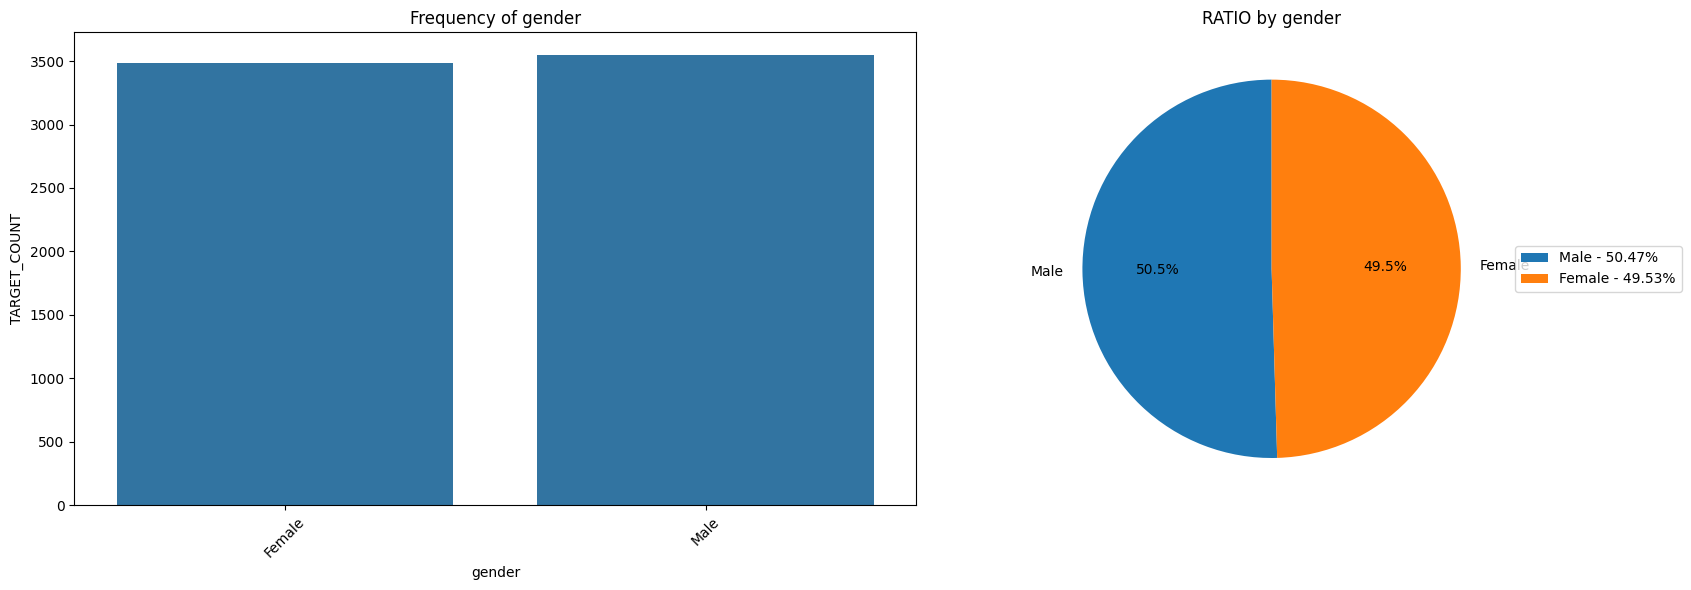

         Partner  Ratio
Partner                
No          3639 51.749
Yes         3393 48.251
##########################################


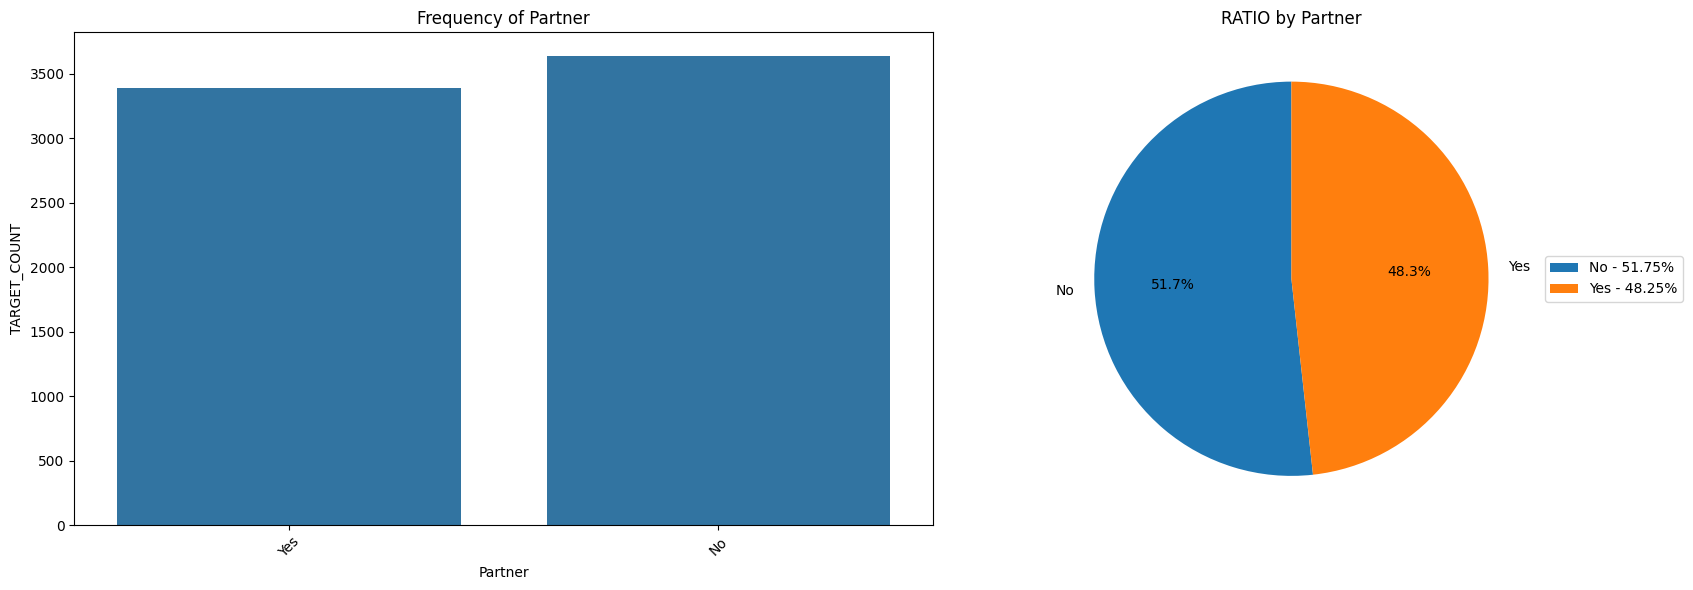

            Dependents  Ratio
Dependents                   
No                4933 70.151
Yes               2099 29.849
##########################################


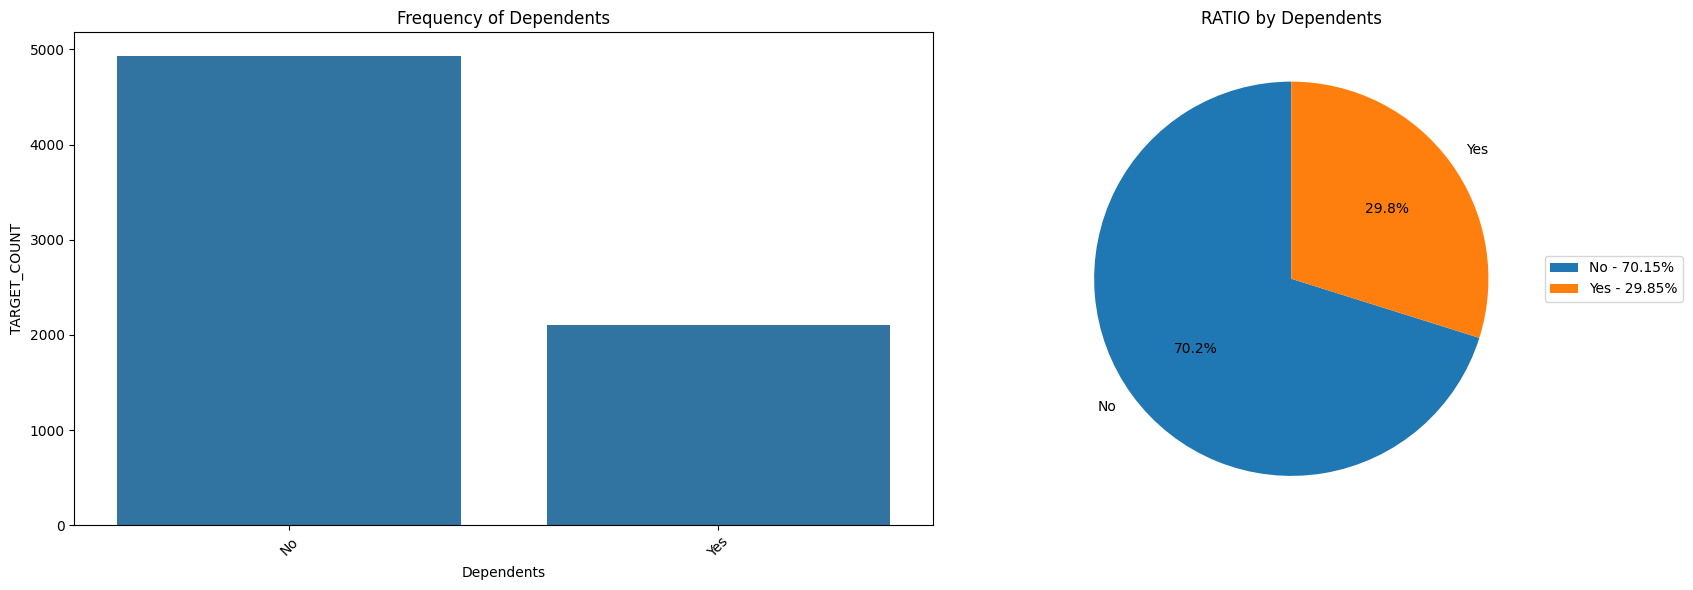

              PhoneService  Ratio
PhoneService                     
Yes                   6352 90.330
No                     680  9.670
##########################################


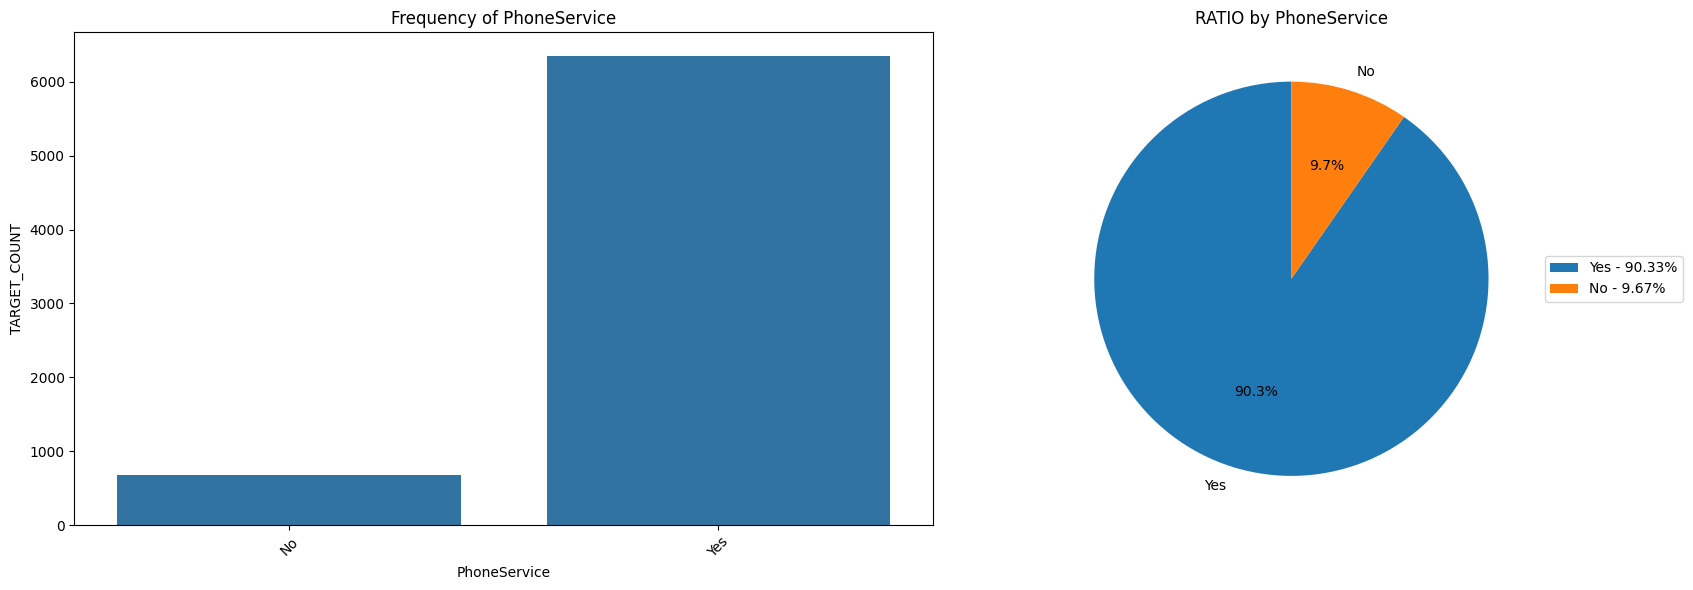

                  MultipleLines  Ratio
MultipleLines                         
No                         3385 48.137
Yes                        2967 42.193
No phone service            680  9.670
##########################################


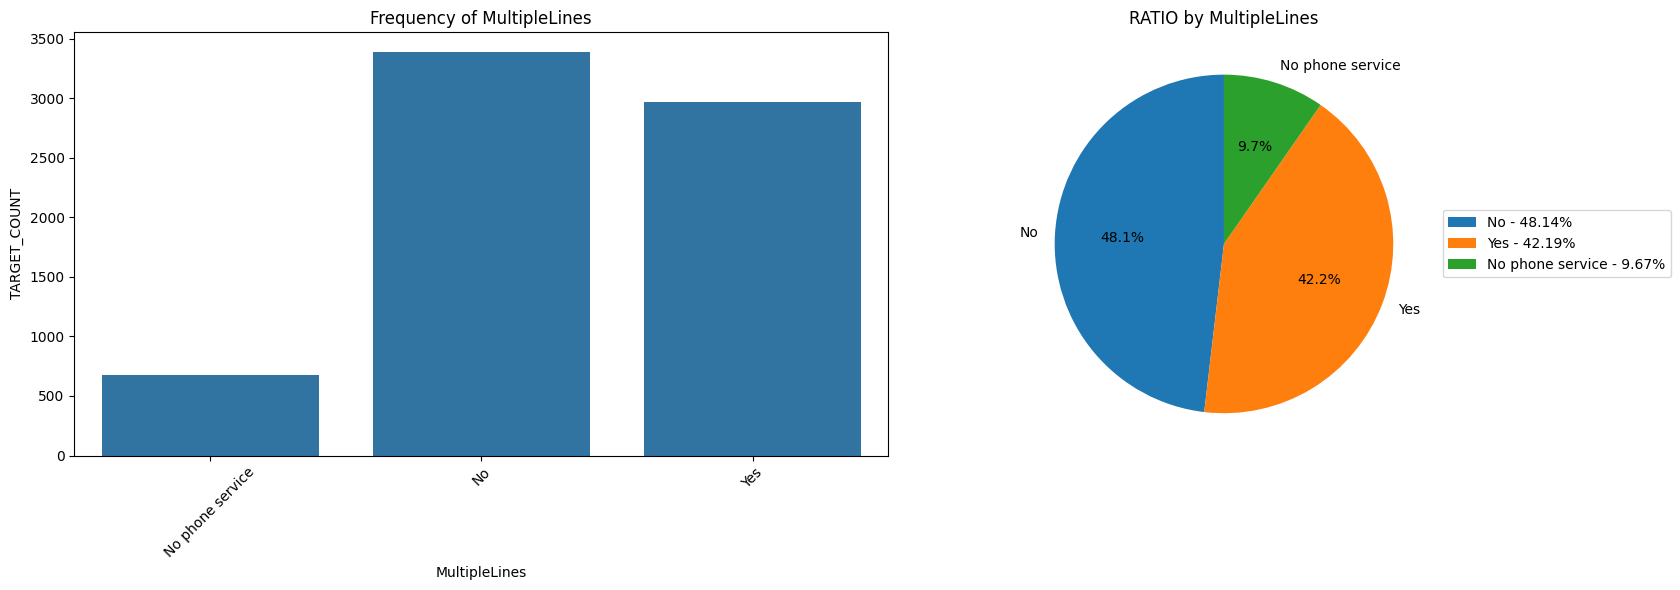

                 InternetService  Ratio
InternetService                        
Fiber optic                 3096 44.027
DSL                         2416 34.357
No                          1520 21.615
##########################################


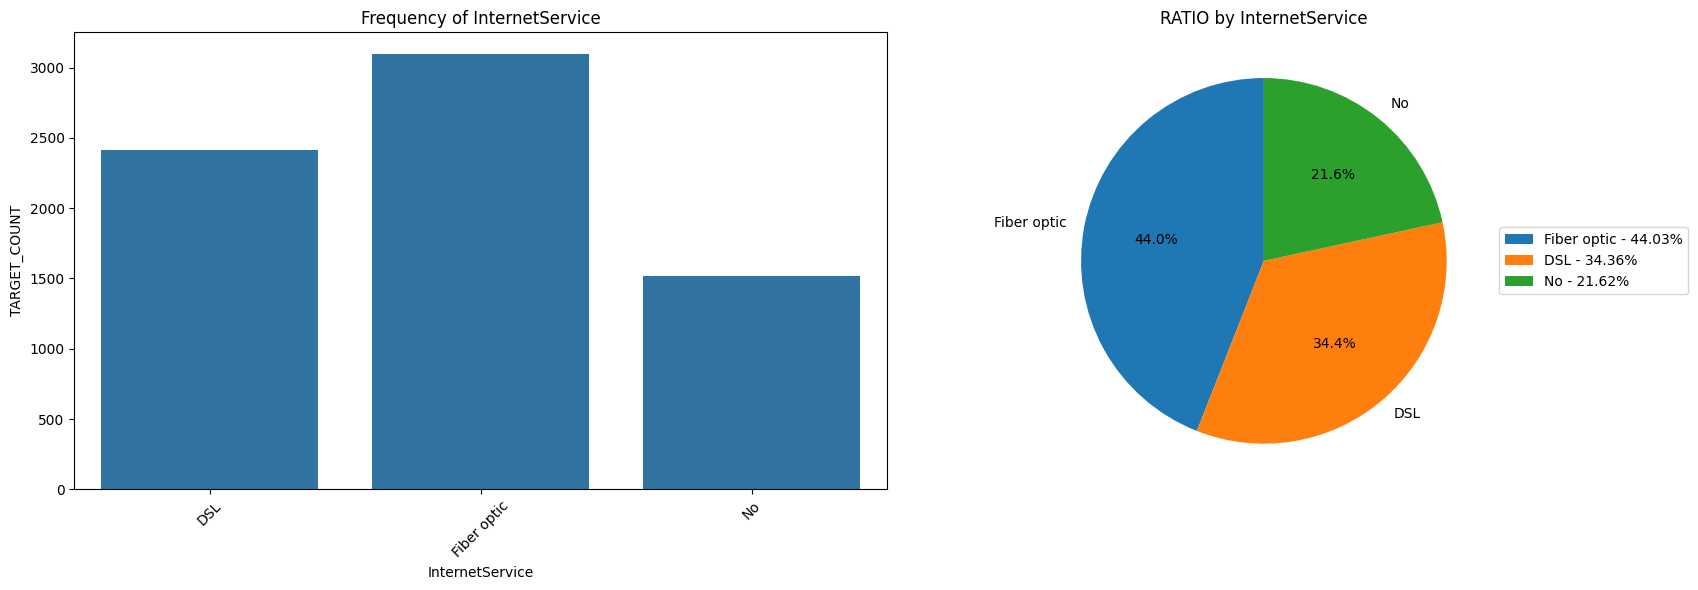

                     OnlineSecurity  Ratio
OnlineSecurity                            
No                             3497 49.730
Yes                            2015 28.655
No internet service            1520 21.615
##########################################


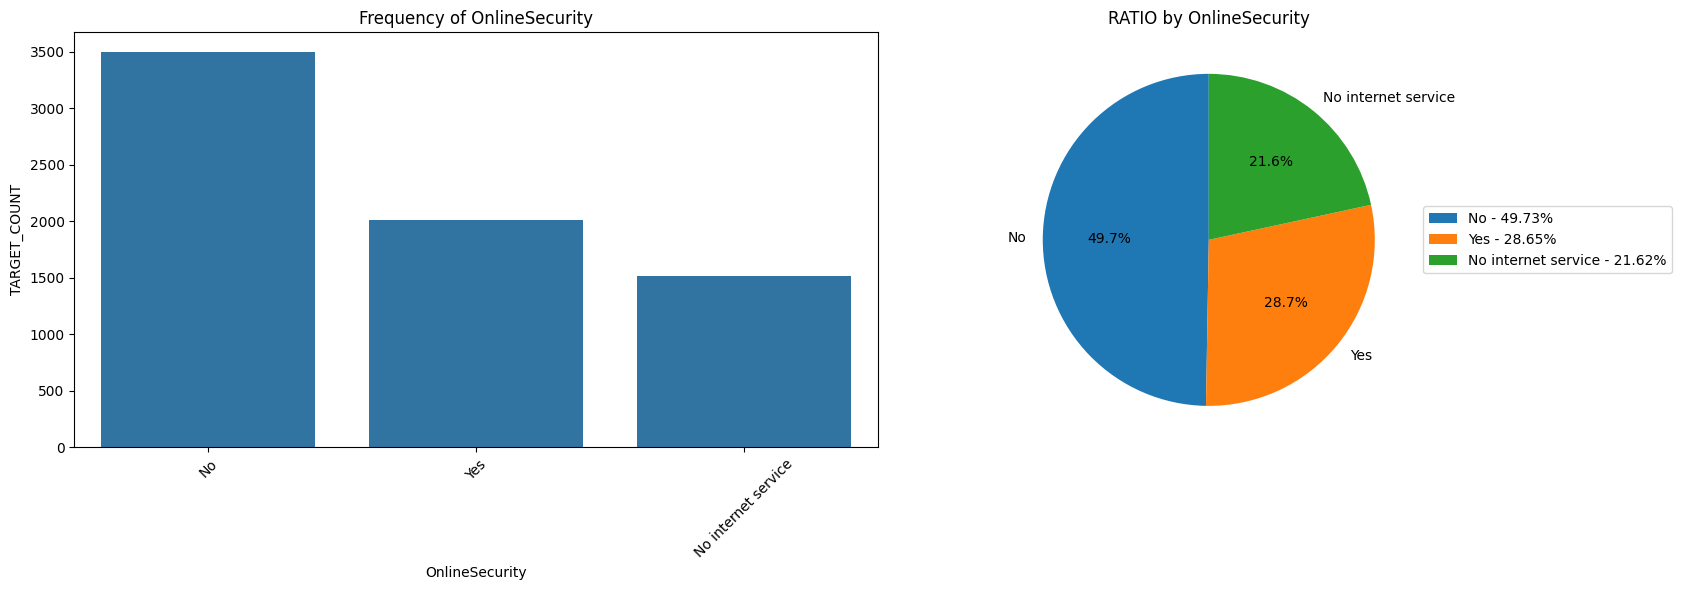

                     OnlineBackup  Ratio
OnlineBackup                            
No                           3087 43.899
Yes                          2425 34.485
No internet service          1520 21.615
##########################################


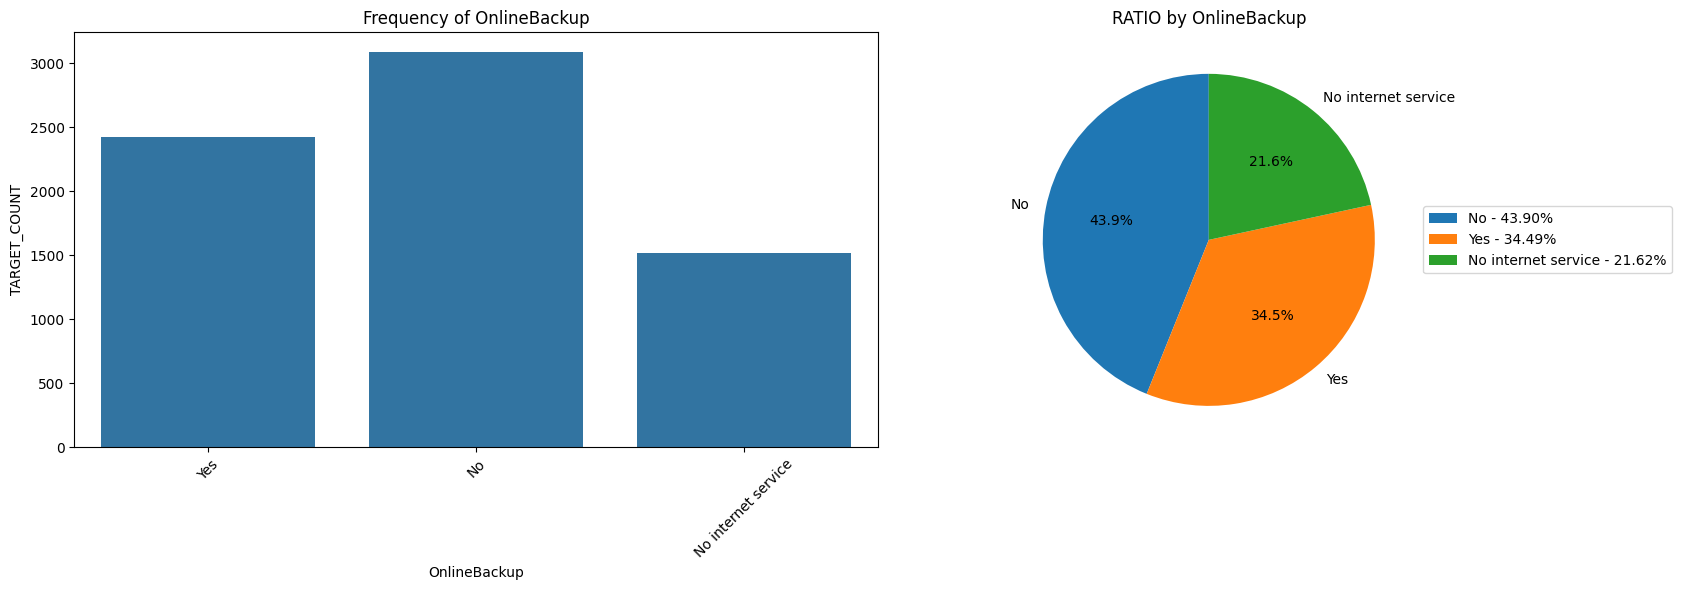

                     DeviceProtection  Ratio
DeviceProtection                            
No                               3094 43.999
Yes                              2418 34.386
No internet service              1520 21.615
##########################################


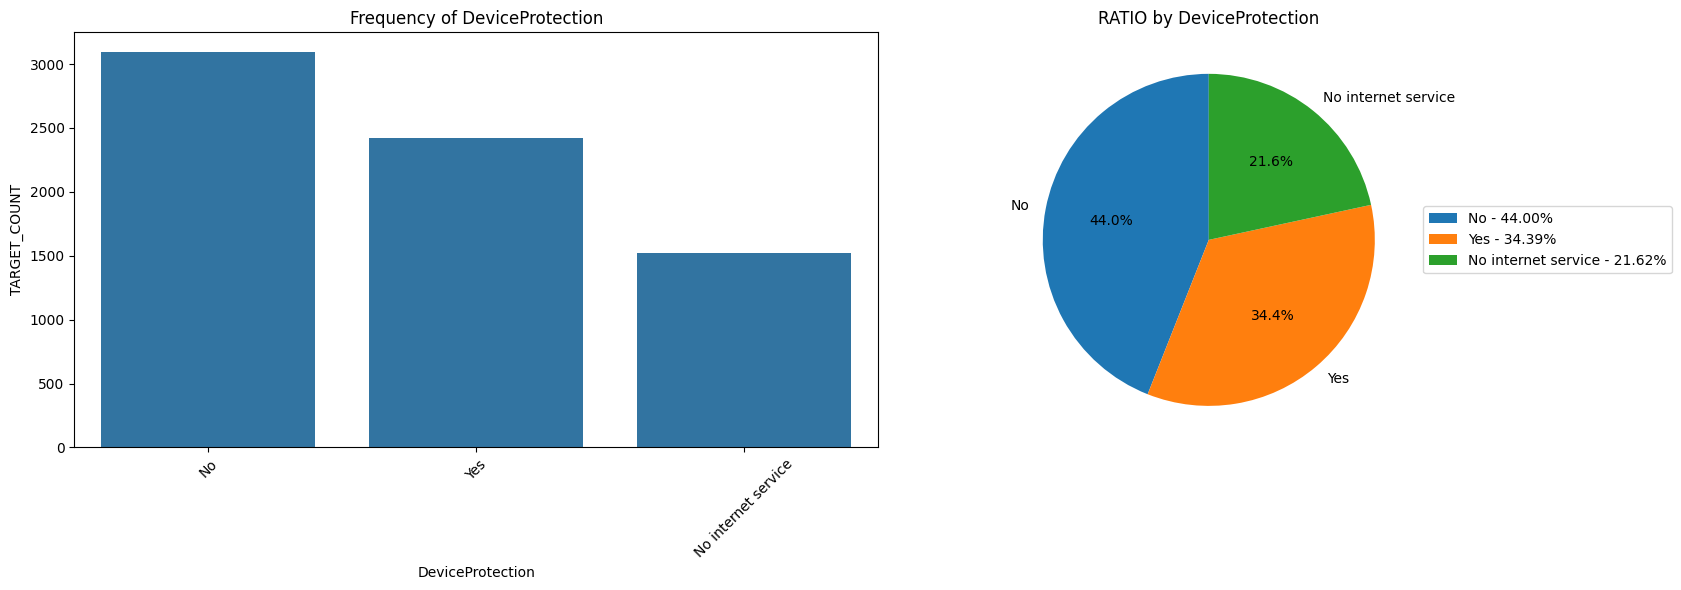

                     TechSupport  Ratio
TechSupport                            
No                          3472 49.374
Yes                         2040 29.010
No internet service         1520 21.615
##########################################


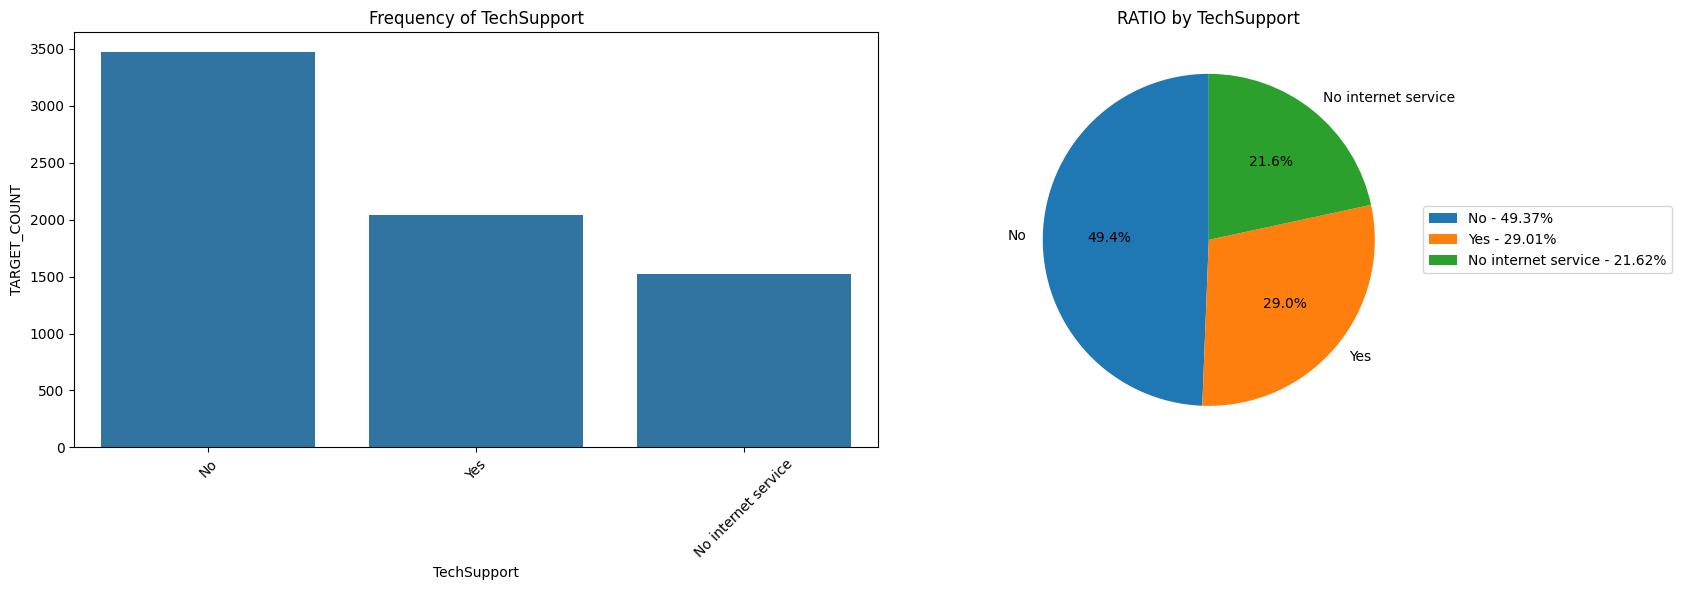

                     StreamingTV  Ratio
StreamingTV                            
No                          2809 39.946
Yes                         2703 38.439
No internet service         1520 21.615
##########################################


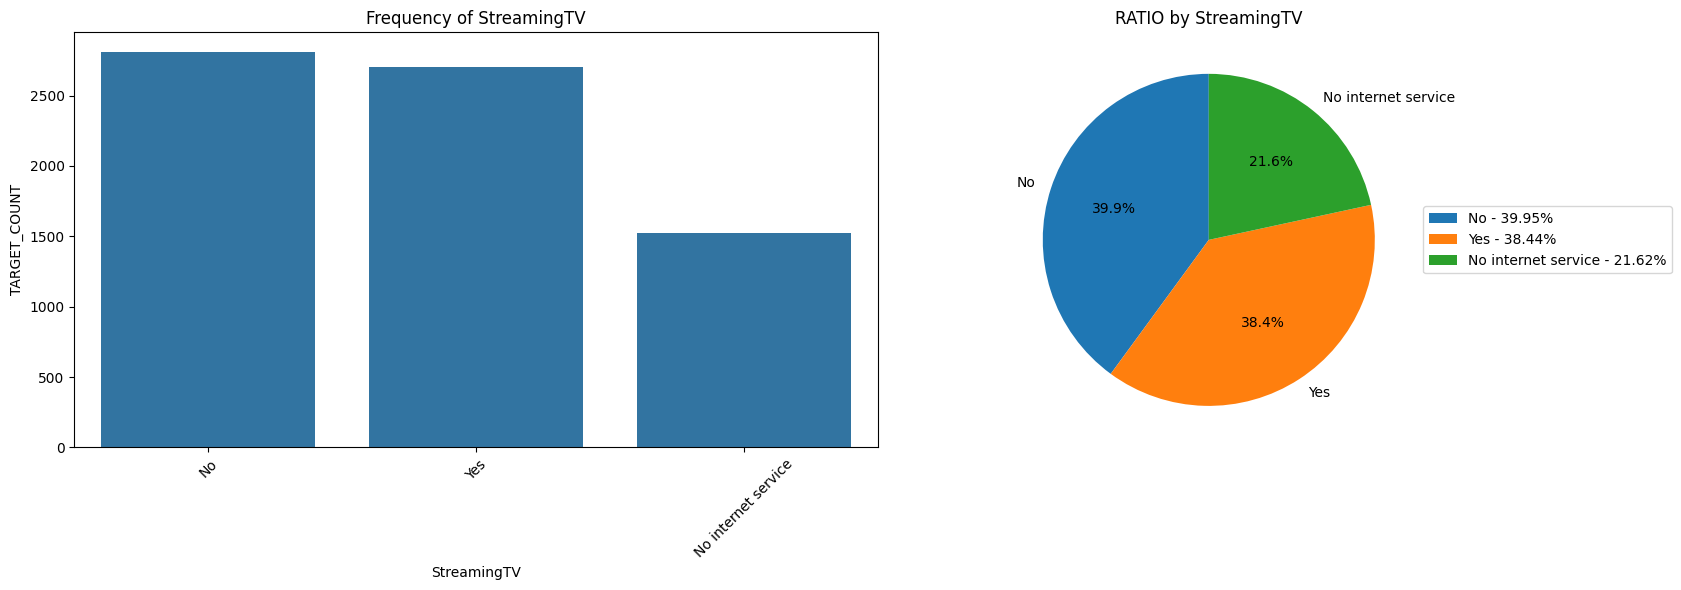

                     StreamingMovies  Ratio
StreamingMovies                            
No                              2781 39.548
Yes                             2731 38.837
No internet service             1520 21.615
##########################################


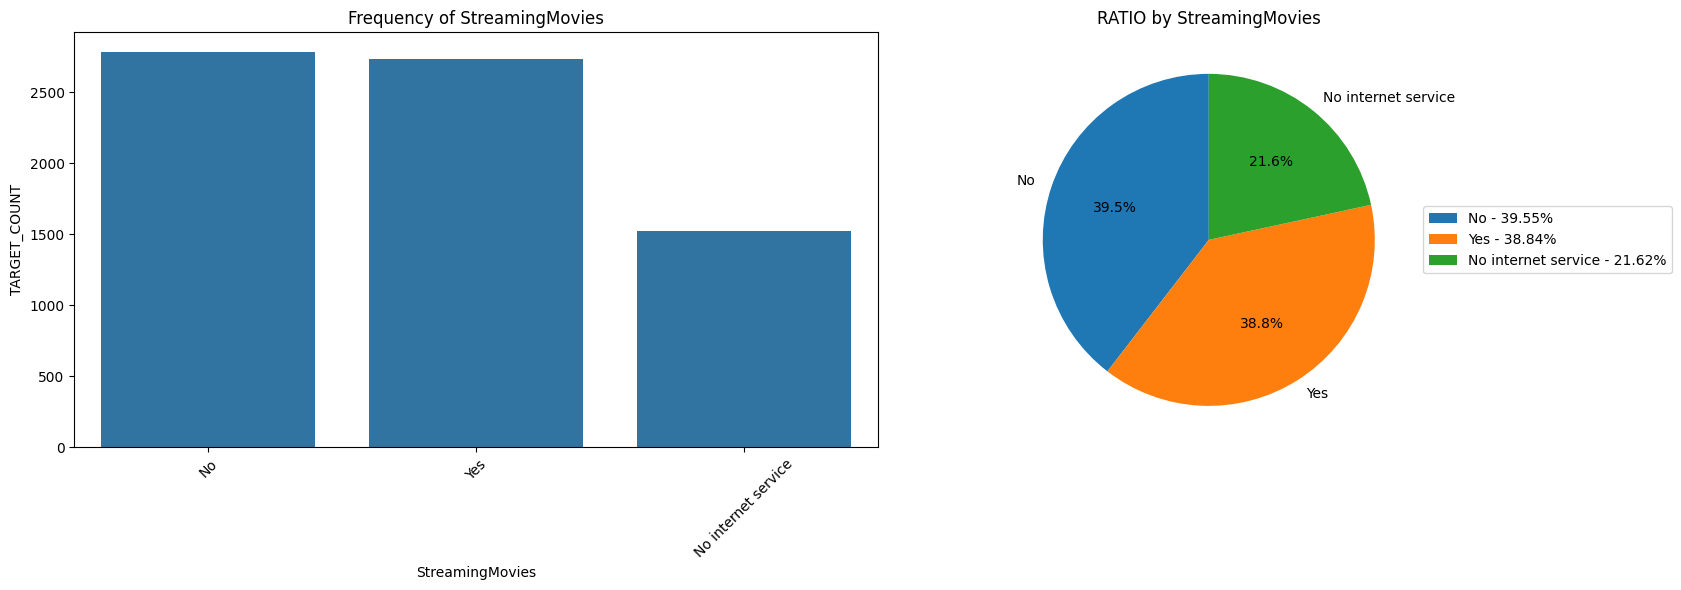

                Contract  Ratio
Contract                       
Month-to-month      3875 55.105
Two year            1685 23.962
One year            1472 20.933
##########################################


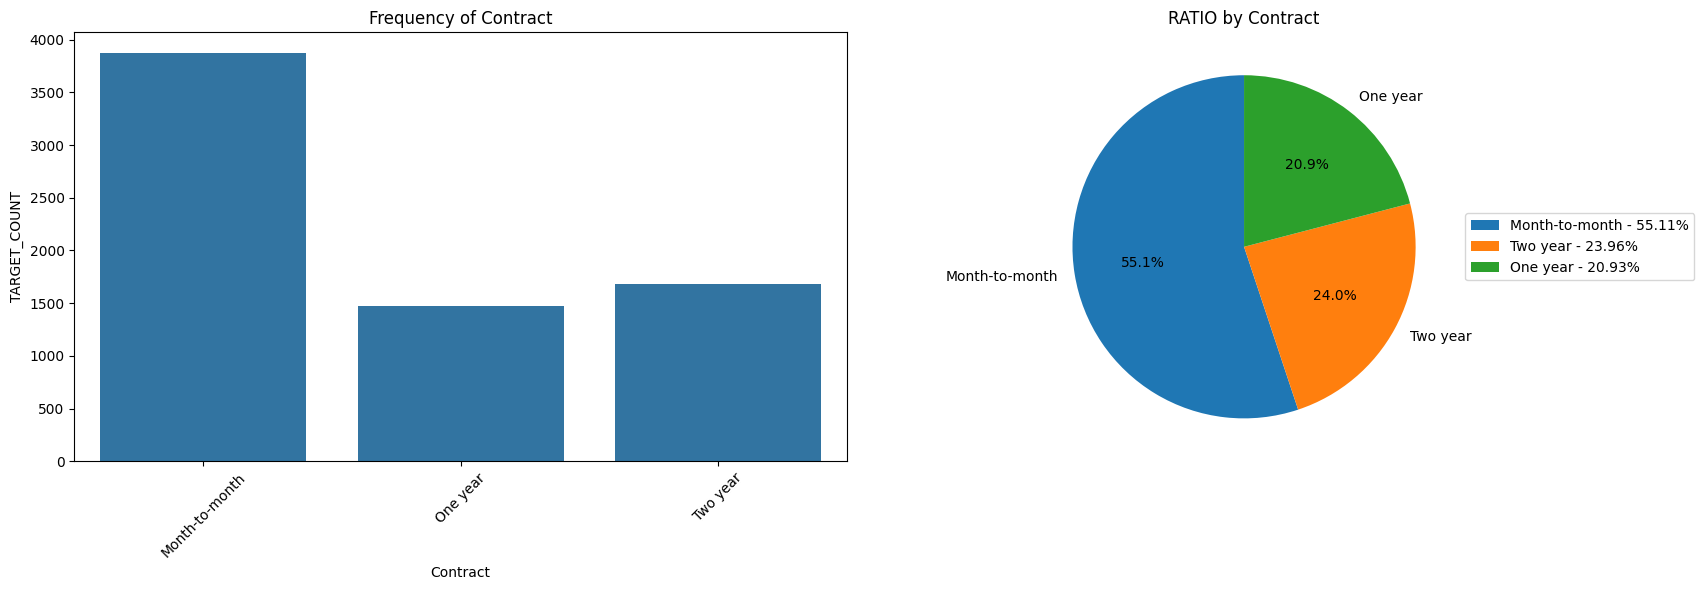

                  PaperlessBilling  Ratio
PaperlessBilling                         
Yes                           4168 59.272
No                            2864 40.728
##########################################


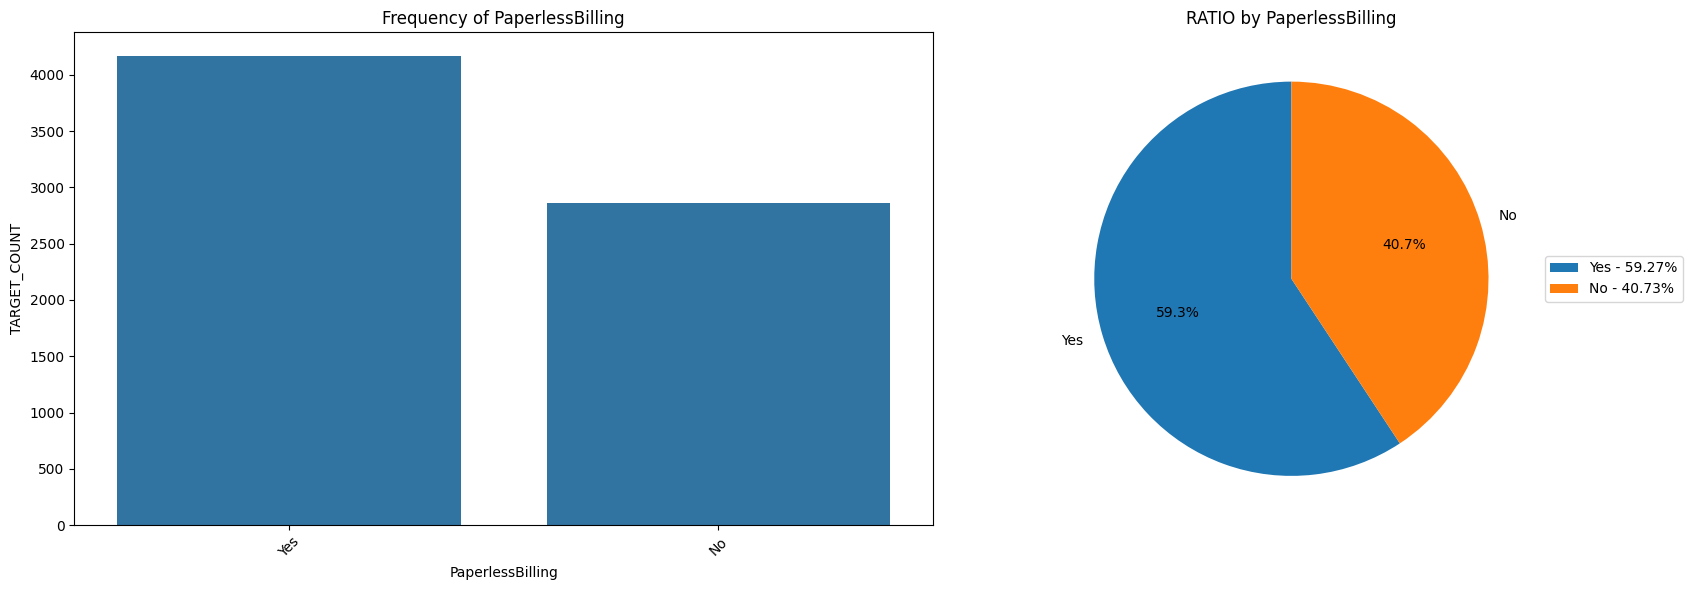

                           PaymentMethod  Ratio
PaymentMethod                                  
Electronic check                    2365 33.632
Mailed check                        1604 22.810
Bank transfer (automatic)           1542 21.928
Credit card (automatic)             1521 21.630
##########################################


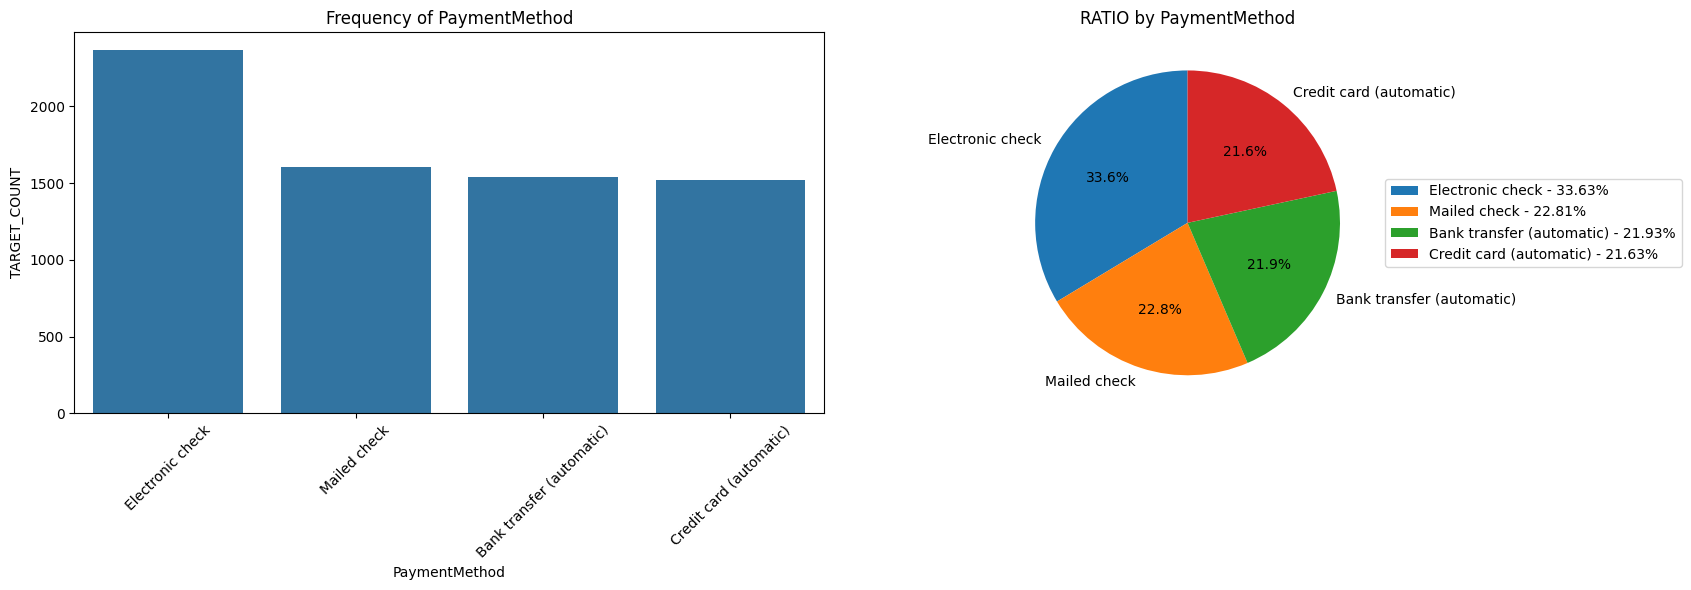

               SeniorCitizen  Ratio
SeniorCitizen                      
0                       5890 83.760
1                       1142 16.240
##########################################


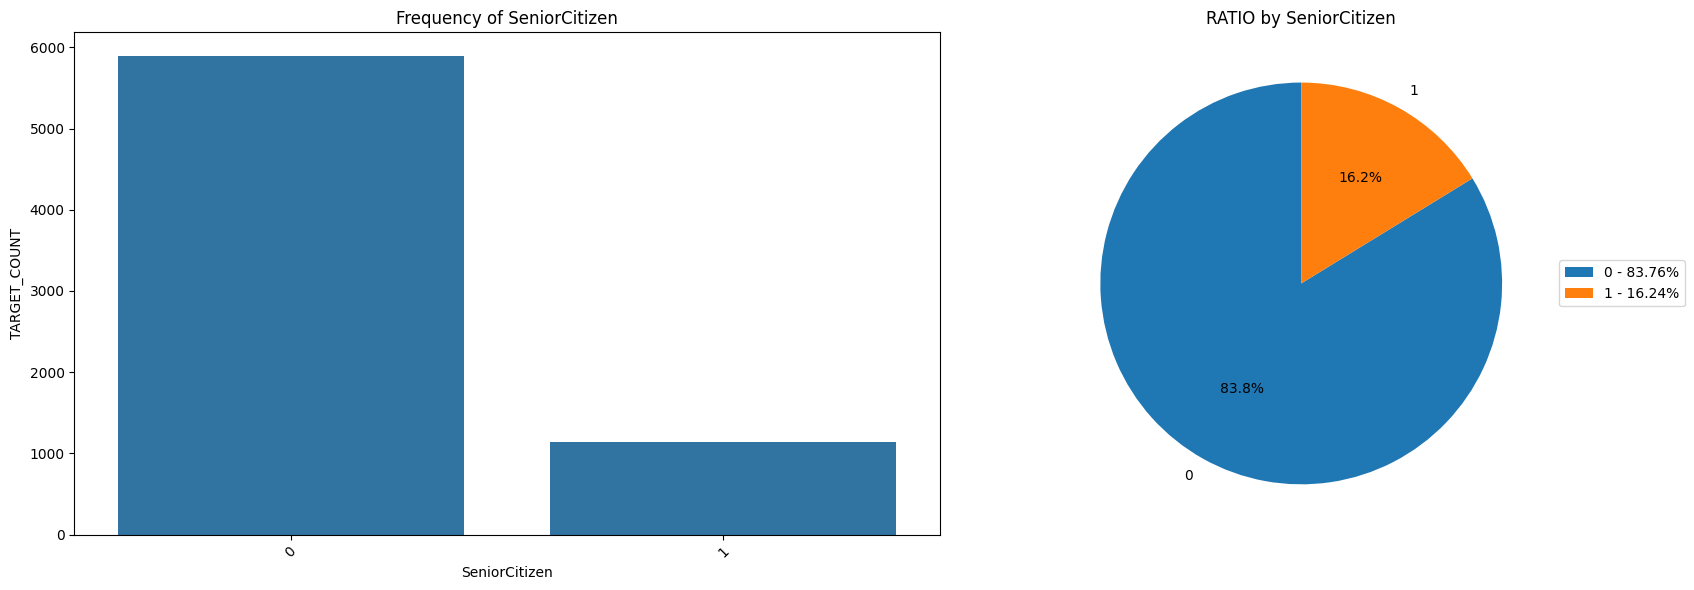

       Churn  Ratio
Churn              
0       5163 73.422
1       1869 26.578
##########################################


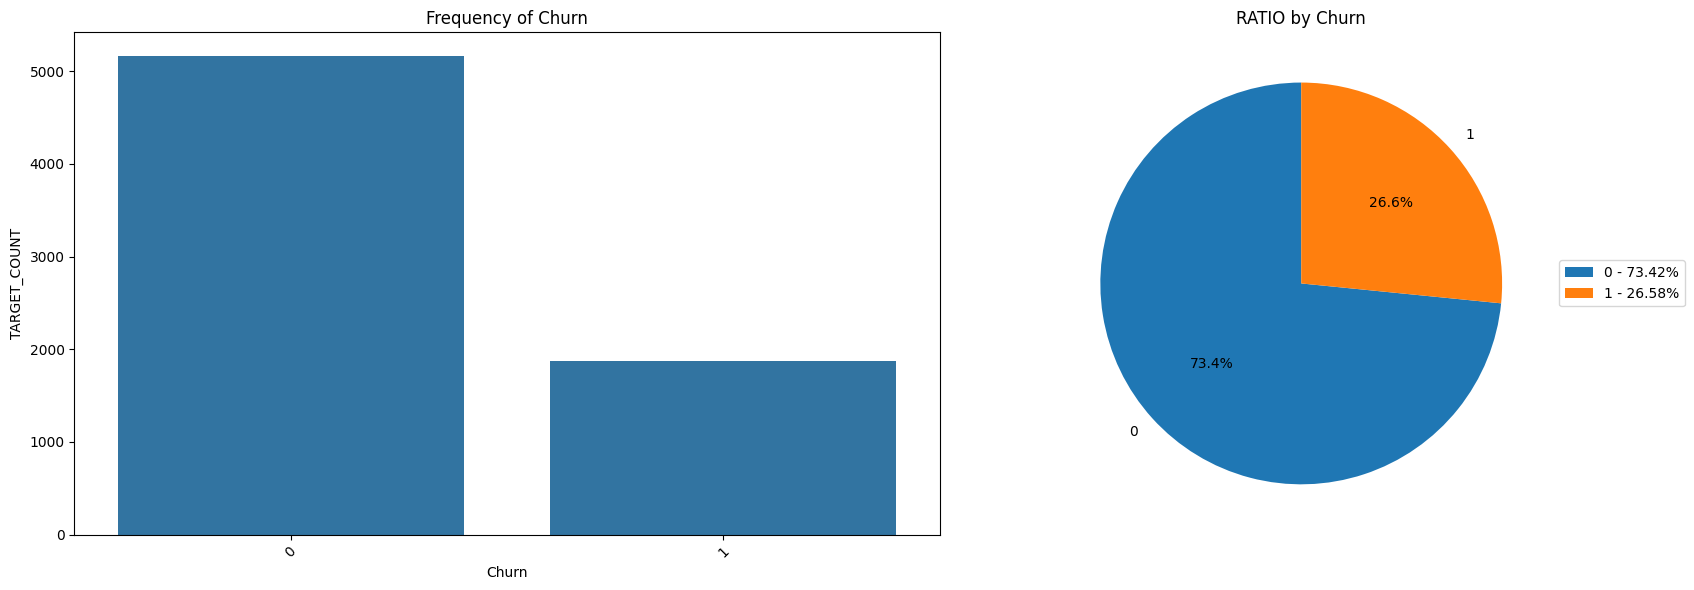

In [30]:
for col in cat_cols:
    cat_summary(df, col, plot=True)

In [31]:
def num_summary(dataframe, numerical_col, plot=False, hist_bins=20):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(numerical_col)
    print("##########################################")
    print(dataframe[numerical_col].describe(quantiles).T)
    print("##########################################")

    if plot:
        fig, axs = plt.subplots(2, 2, figsize=(12, 10))

        # Histogram
        plt.subplot(2, 2, 1)
        dataframe[numerical_col].hist(bins=hist_bins)
        plt.xlabel(numerical_col)
        plt.title(numerical_col + " Distribution")

        # Boxplot
        plt.subplot(2, 2, 2)
        sns.boxplot(y=numerical_col, data=dataframe)
        plt.title("Boxplot of " + numerical_col)
        plt.xticks(rotation=90)

        # Density Plot
        plt.subplot(2, 2, 3)
        sns.kdeplot(dataframe[numerical_col], fill=True)
        plt.xlabel(numerical_col)
        plt.title(numerical_col + " Density")

        # QQ Plot
        plt.subplot(2, 2, 4)
        stats.probplot(dataframe[numerical_col], dist="norm", plot=plt)
        plt.title(numerical_col + " QQ Plot")

        plt.tight_layout()
        plt.show(block=True)

tenure
##########################################
count   7032.000
mean      32.422
std       24.545
min        1.000
5%         1.000
10%        2.000
20%        6.000
30%       12.000
40%       20.000
50%       29.000
60%       40.000
70%       50.000
80%       60.800
90%       69.000
95%       72.000
99%       72.000
max       72.000
Name: tenure, dtype: float64
##########################################


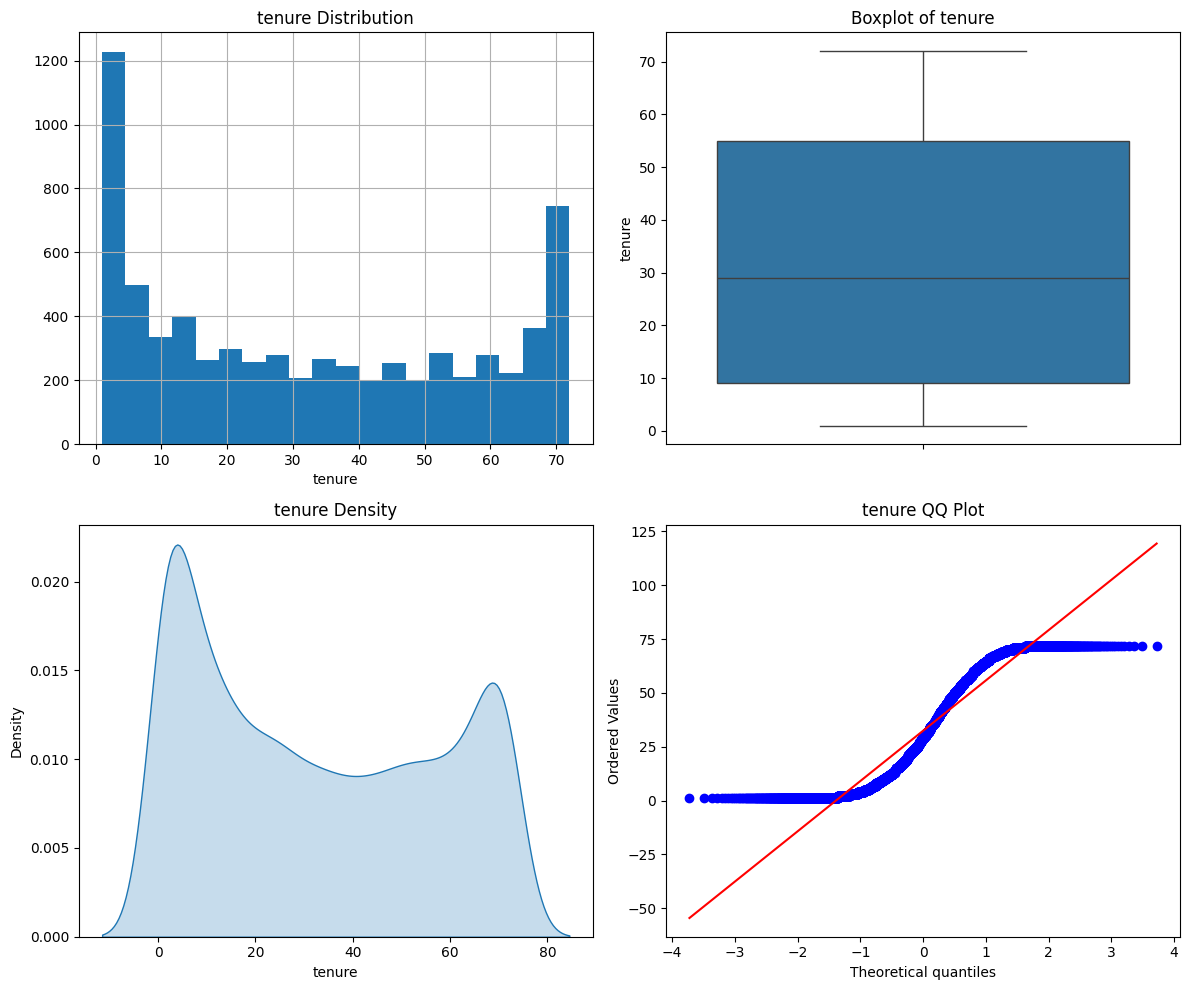

MonthlyCharges
##########################################
count   7032.000
mean      64.798
std       30.086
min       18.250
5%        19.650
10%       20.050
20%       25.050
30%       45.900
40%       58.920
50%       70.350
60%       79.150
70%       85.535
80%       94.300
90%      102.645
95%      107.422
99%      114.734
max      118.750
Name: MonthlyCharges, dtype: float64
##########################################


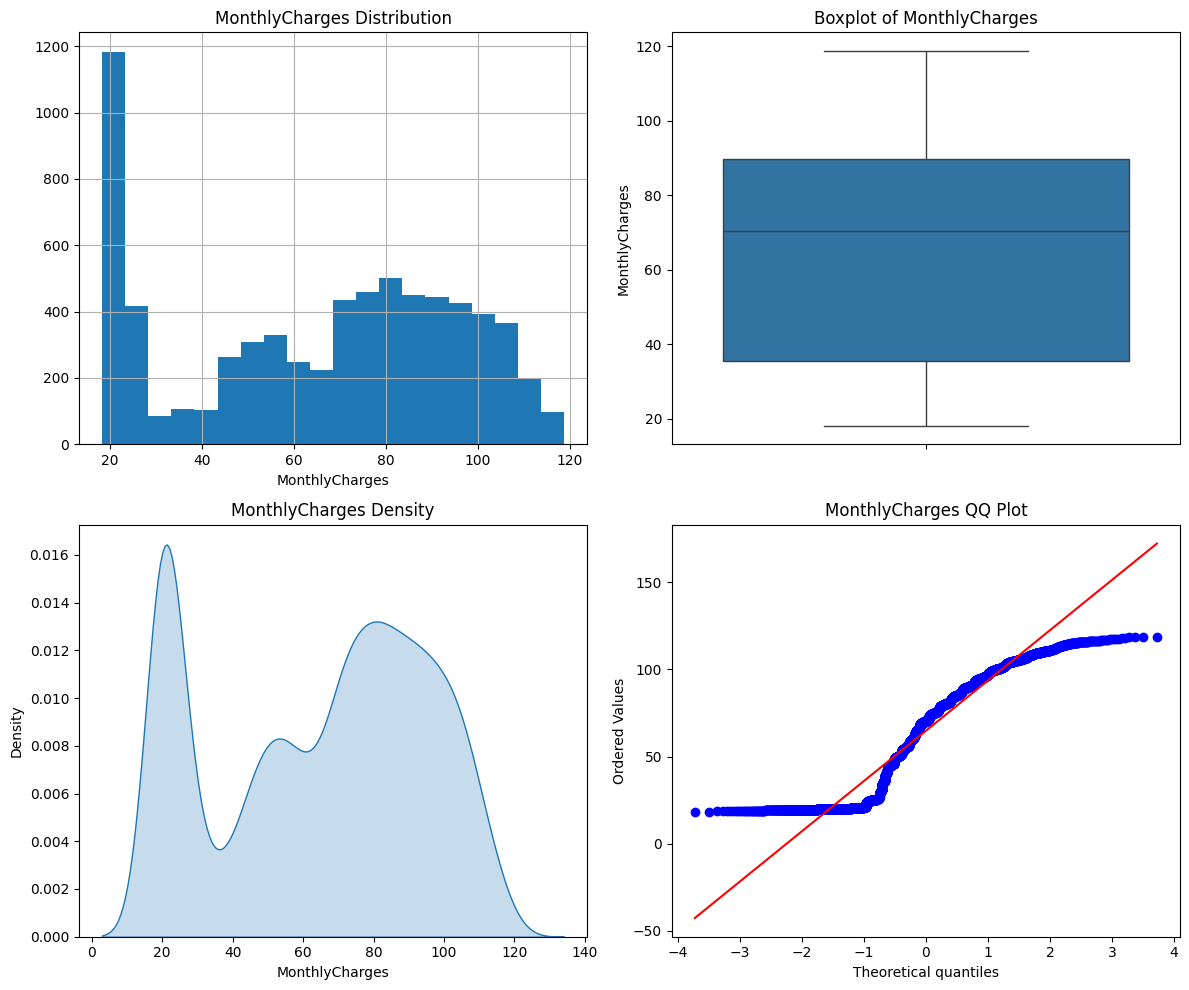

TotalCharges
##########################################
count   7032.000
mean    2283.300
std     2266.771
min       18.800
5%        49.605
10%       84.600
20%      267.070
30%      551.995
40%      944.170
50%     1397.475
60%     2048.950
70%     3141.130
80%     4475.410
90%     5976.640
95%     6923.590
99%     8039.883
max     8684.800
Name: TotalCharges, dtype: float64
##########################################


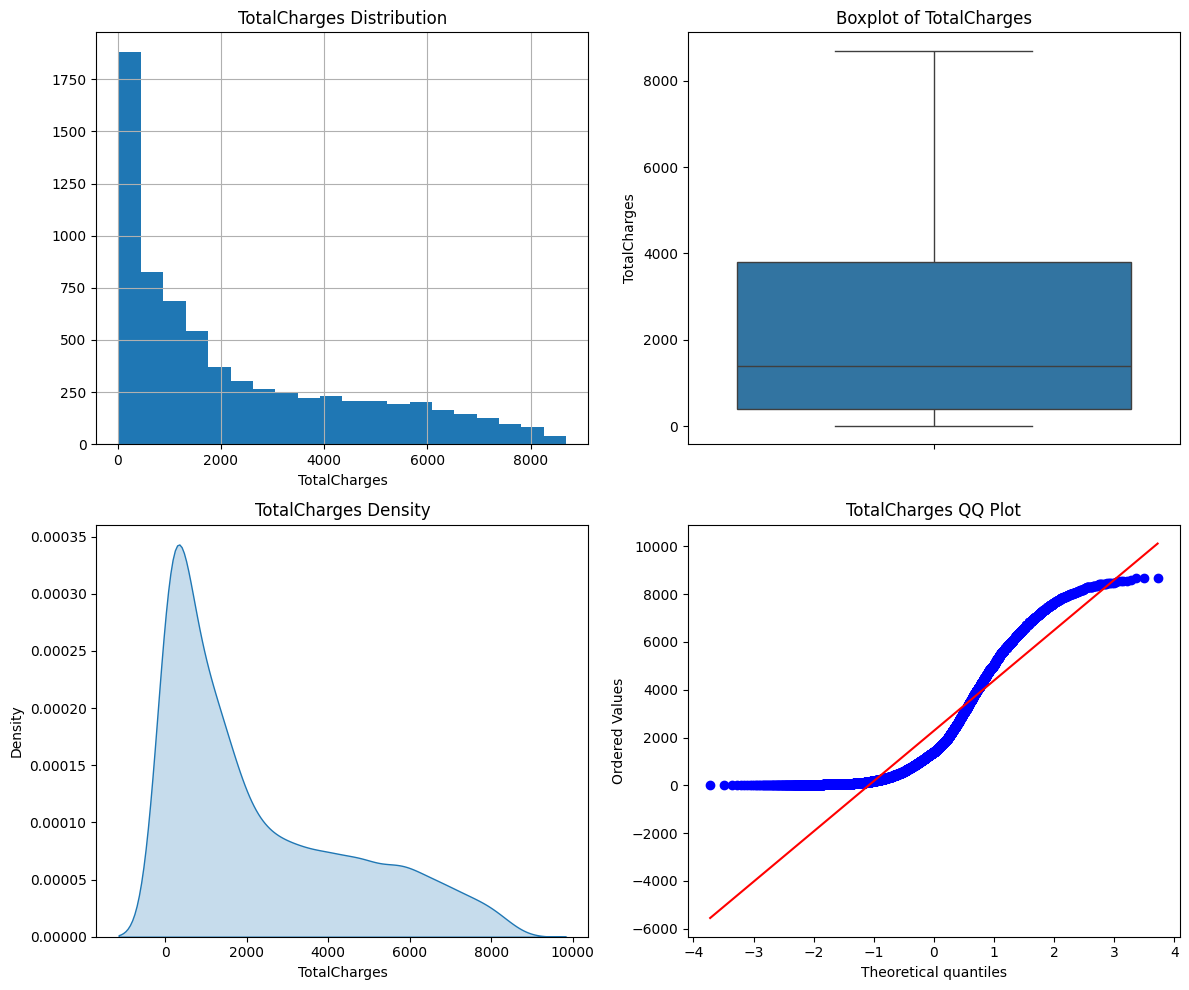

In [32]:
for col in num_cols:
    num_summary(df, col, plot=True)

In [36]:
def target_summary_with_cat(dataframe, target, categorical_col, plot=False):
    summary = pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean(),
                            "TARGET_COUNT": dataframe.groupby(categorical_col)[target].count(),
                            "RATIO": 100 * dataframe[categorical_col].value_counts() / len(dataframe)})

    print(summary, end="\n\n\n")
    print("##########################################")

    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

        # TARGET_MEAN
        summary["TARGET_MEAN"].plot(kind="bar", ax=ax1)
        ax1.set_title(f"TARGET_MEAN by {categorical_col}")
        ax1.set_ylabel("TARGET_MEAN")
        ax1.tick_params(axis="x", rotation=45)

        # TARGET_COUNT
        sns.countplot(x=categorical_col, data=dataframe, ax=ax2)
        ax2.set_title(f"Frequency of {categorical_col}")
        ax2.set_ylabel("TARGET_COUNT")
        ax2.tick_params(axis="x", rotation=45)

        # RATIO
        values = dataframe[categorical_col].value_counts()
        ax3.pie(x=values, labels=values.index, autopct="%1.1f%%", startangle=90)
        ax3.set_title(f"RATIO by {categorical_col}")
        ax3.legend(labels=[f"{index} - {value/sum(values)*100:.2f}%" for index, value in zip(values.index, values)],
                   loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

        plt.tight_layout()
        plt.show(block=True)

        TARGET_MEAN  TARGET_COUNT  RATIO
gender                                  
Female        0.270          3483 49.531
Male          0.262          3549 50.469


##########################################


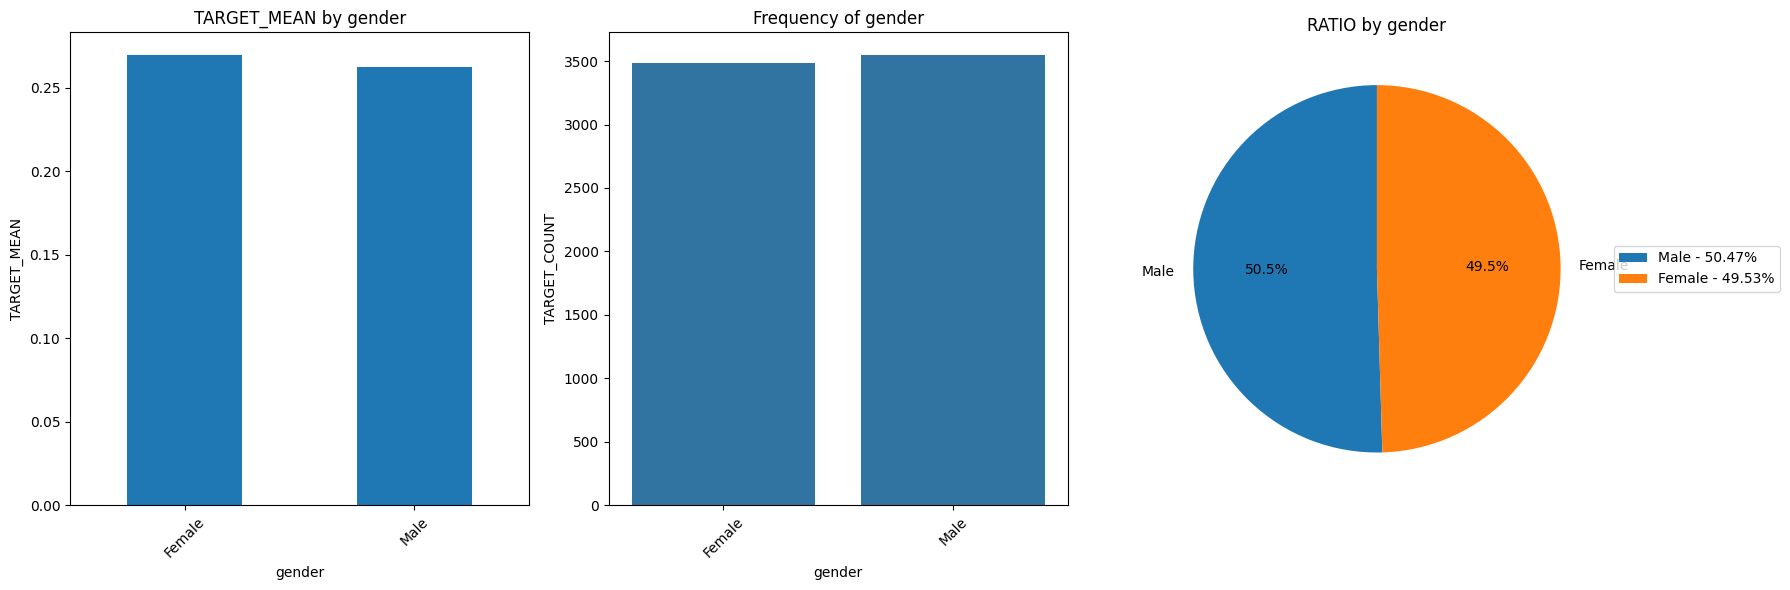

         TARGET_MEAN  TARGET_COUNT  RATIO
Partner                                  
No             0.330          3639 51.749
Yes            0.197          3393 48.251


##########################################


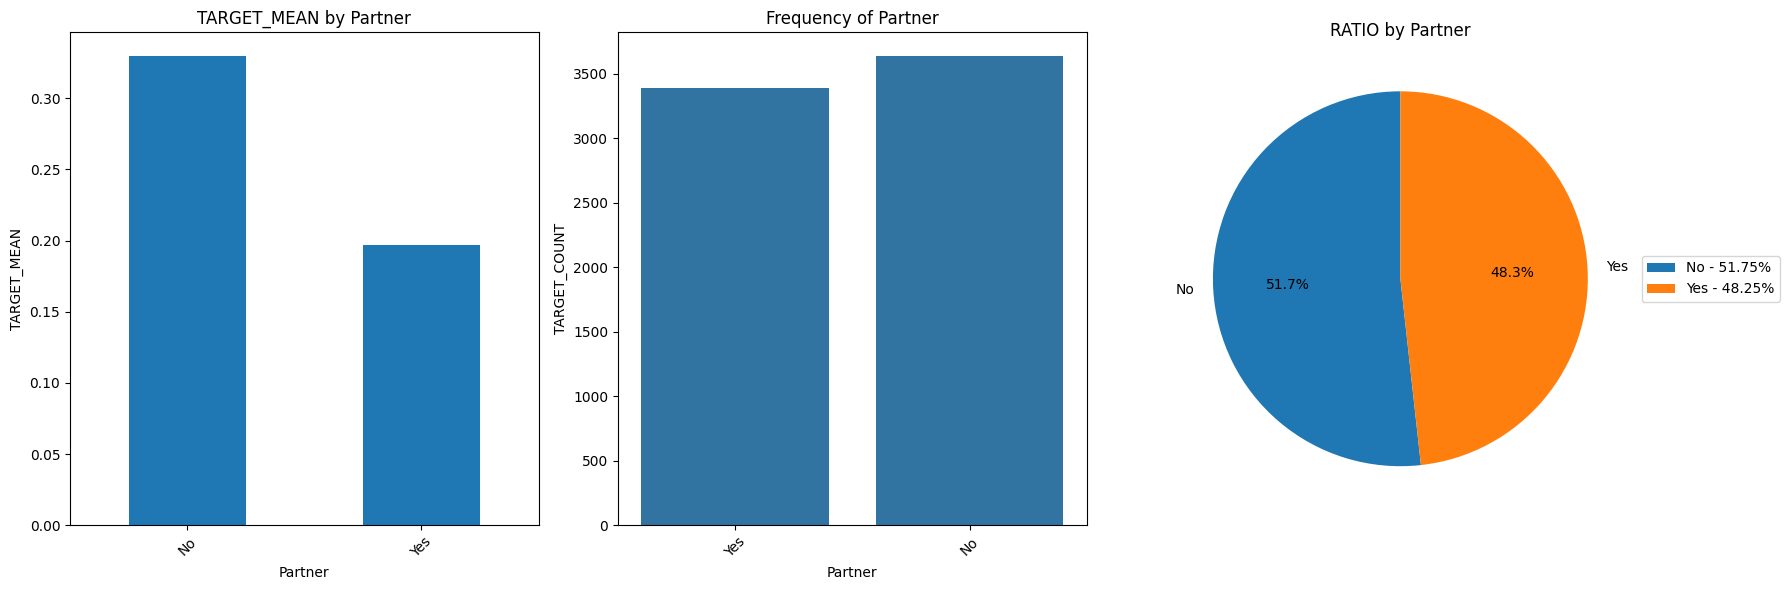

            TARGET_MEAN  TARGET_COUNT  RATIO
Dependents                                  
No                0.313          4933 70.151
Yes               0.155          2099 29.849


##########################################


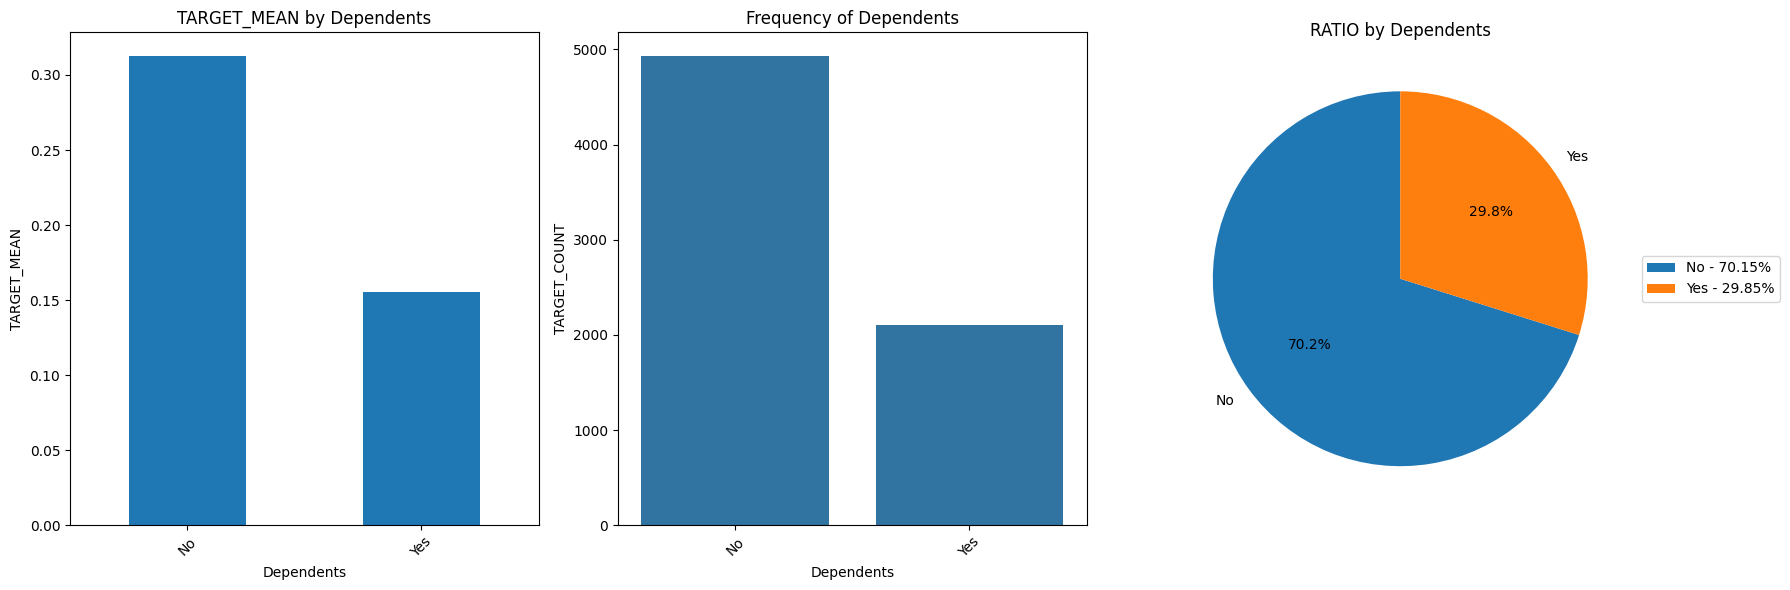

              TARGET_MEAN  TARGET_COUNT  RATIO
PhoneService                                  
No                  0.250           680  9.670
Yes                 0.267          6352 90.330


##########################################


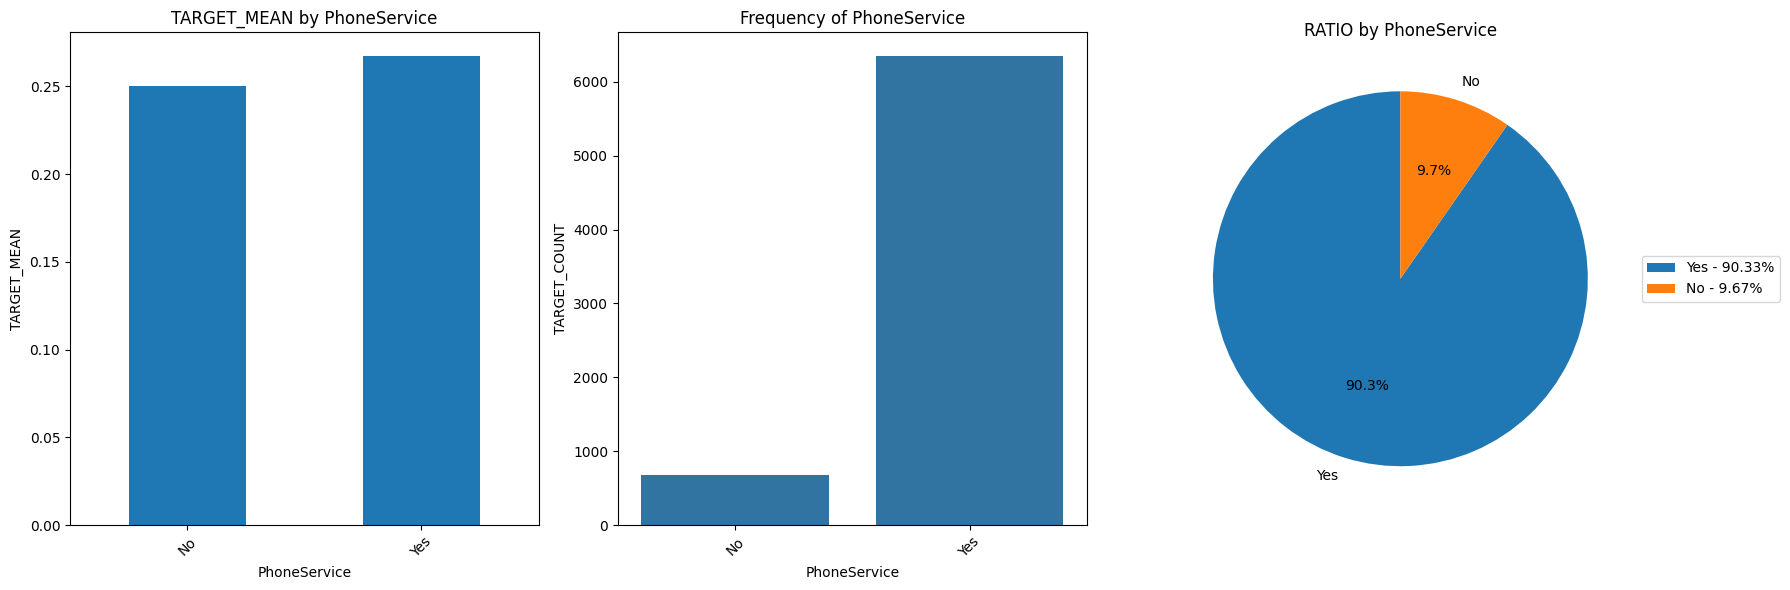

                  TARGET_MEAN  TARGET_COUNT  RATIO
MultipleLines                                     
No                      0.251          3385 48.137
No phone service        0.250           680  9.670
Yes                     0.286          2967 42.193


##########################################


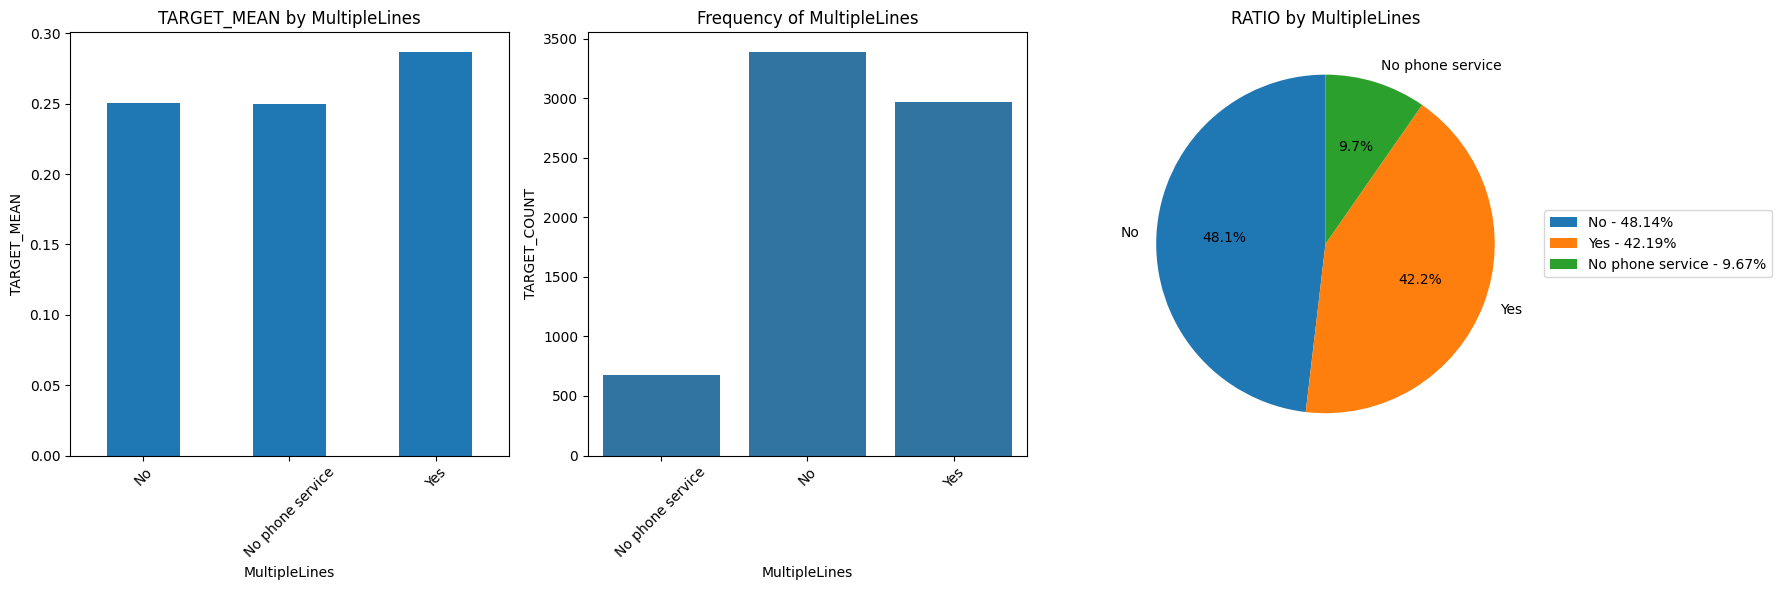

                 TARGET_MEAN  TARGET_COUNT  RATIO
InternetService                                  
DSL                    0.190          2416 34.357
Fiber optic            0.419          3096 44.027
No                     0.074          1520 21.615


##########################################


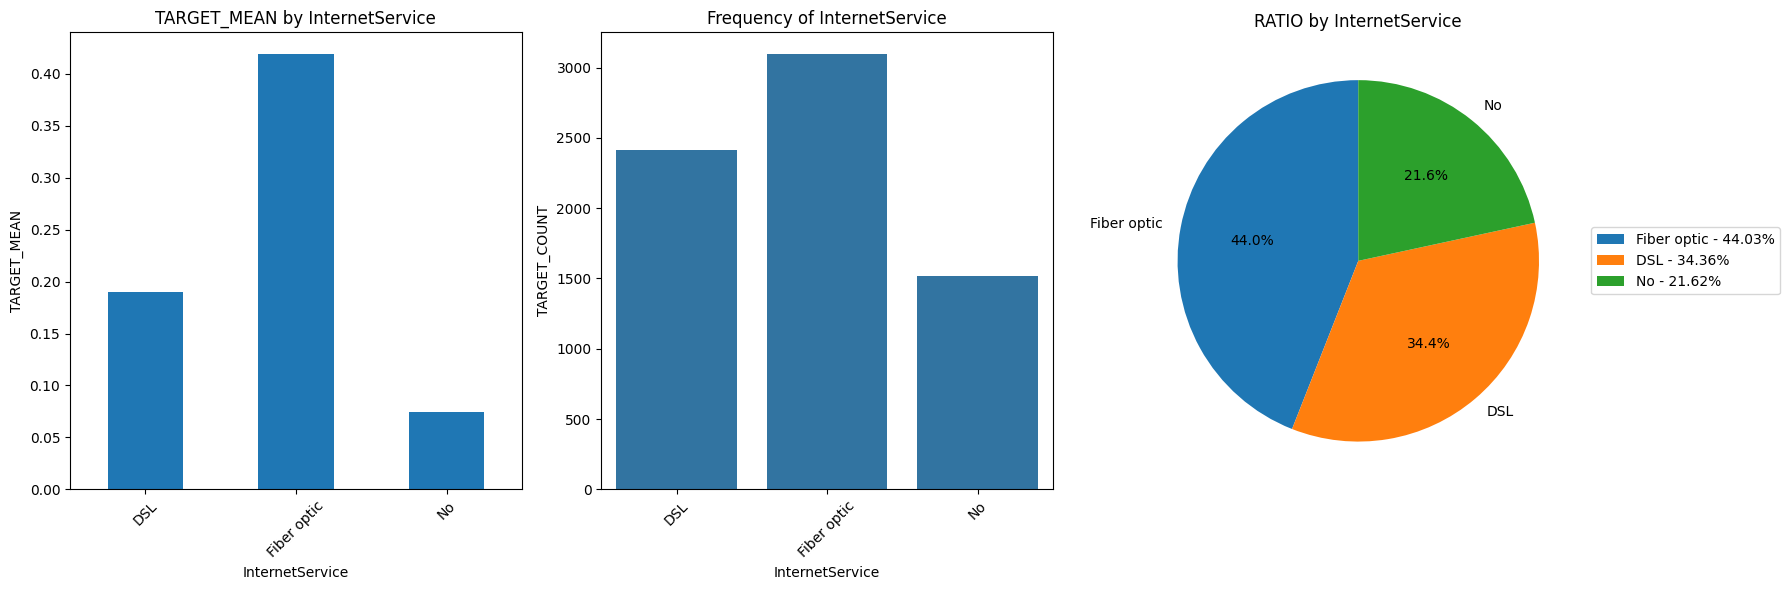

                     TARGET_MEAN  TARGET_COUNT  RATIO
OnlineSecurity                                       
No                         0.418          3497 49.730
No internet service        0.074          1520 21.615
Yes                        0.146          2015 28.655


##########################################


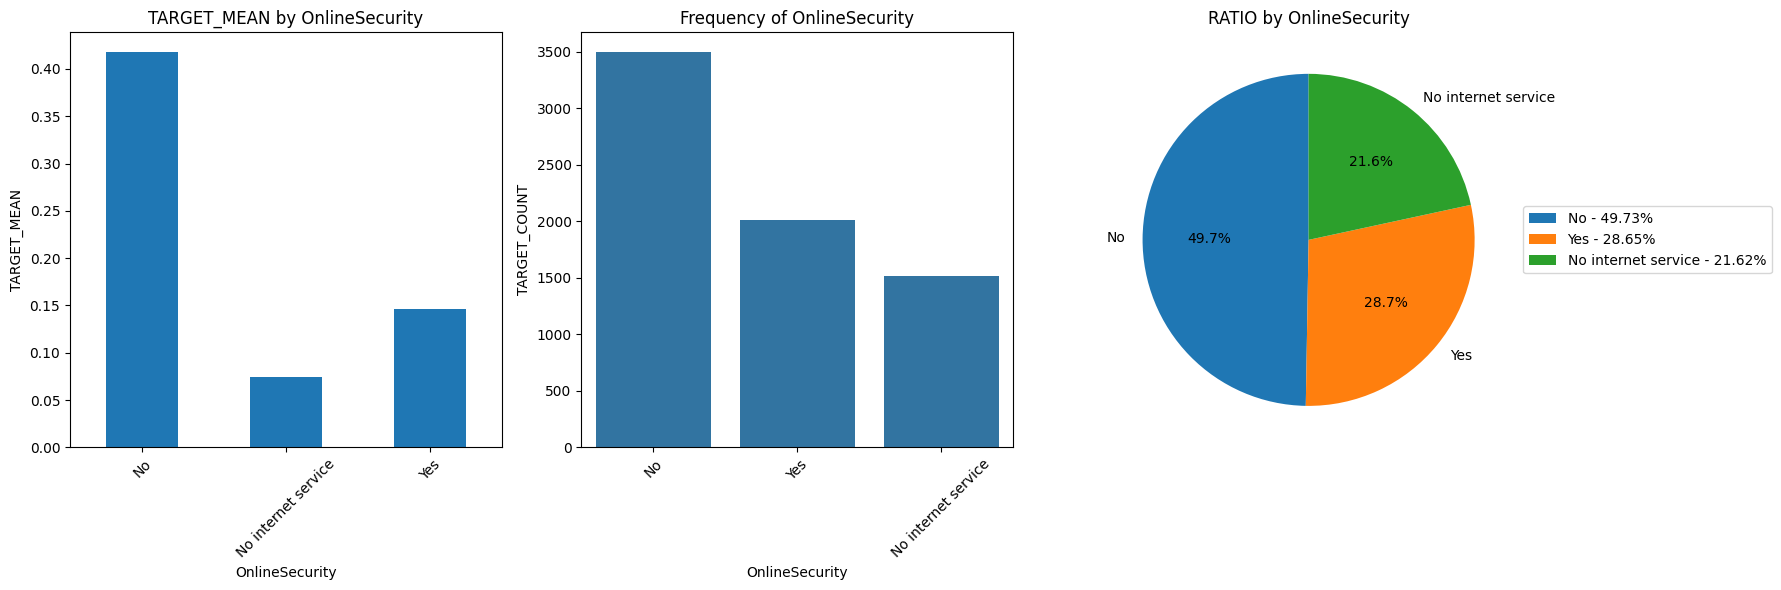

                     TARGET_MEAN  TARGET_COUNT  RATIO
OnlineBackup                                         
No                         0.399          3087 43.899
No internet service        0.074          1520 21.615
Yes                        0.216          2425 34.485


##########################################


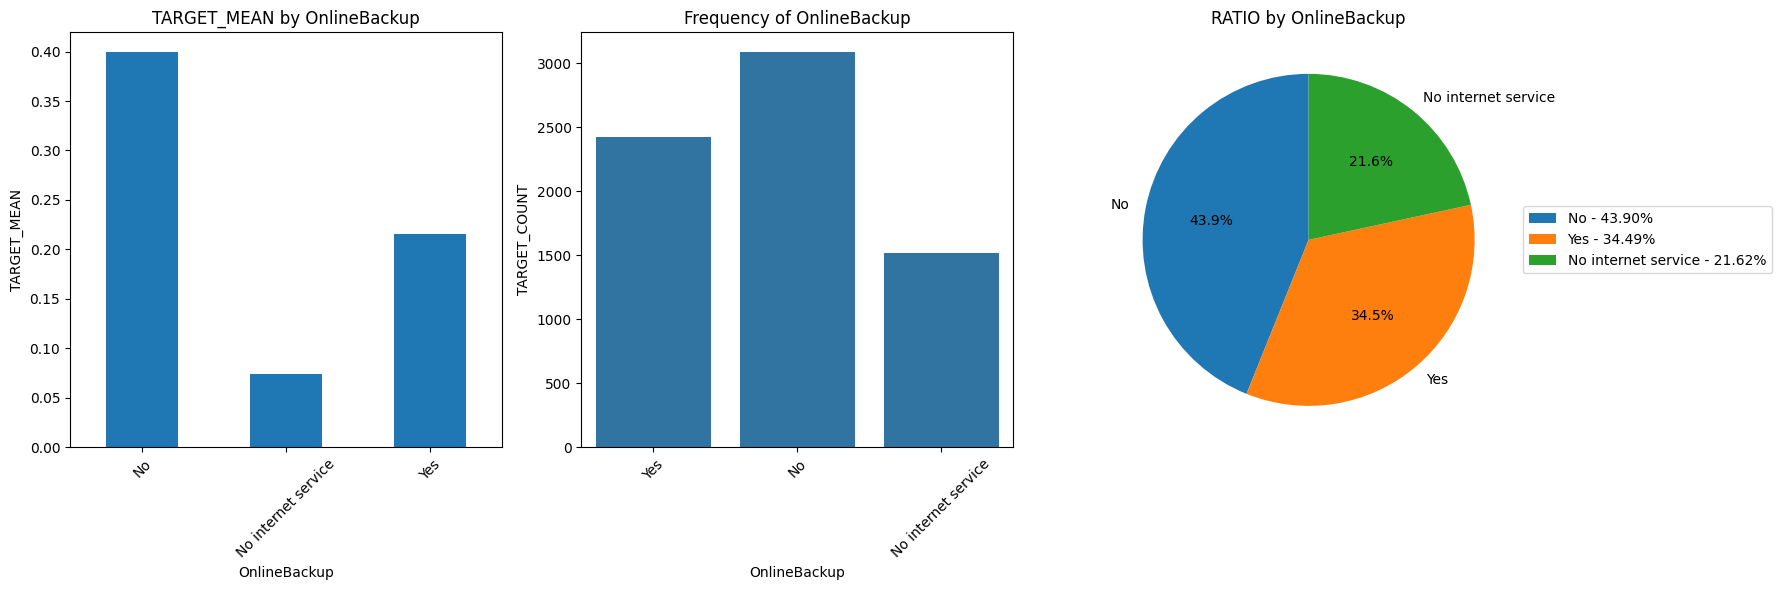

                     TARGET_MEAN  TARGET_COUNT  RATIO
DeviceProtection                                     
No                         0.391          3094 43.999
No internet service        0.074          1520 21.615
Yes                        0.225          2418 34.386


##########################################


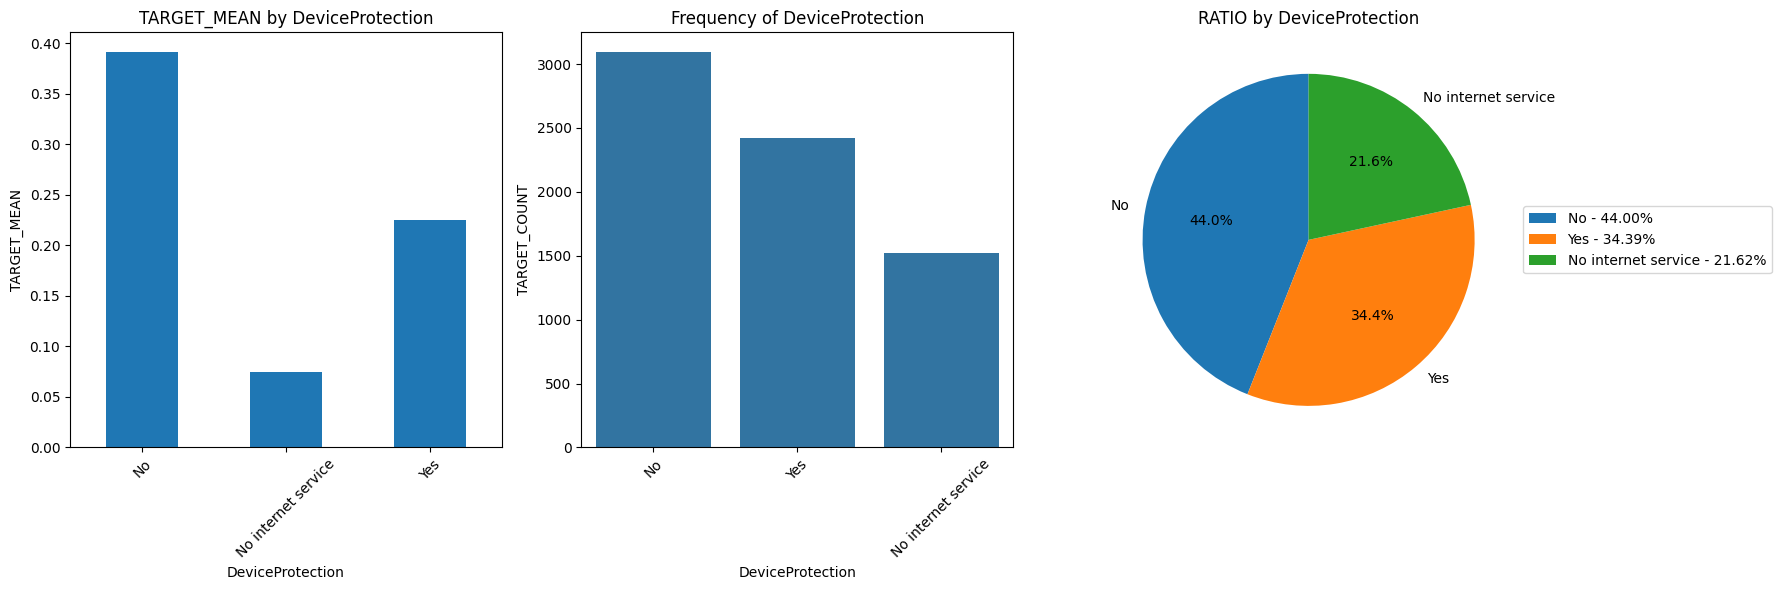

                     TARGET_MEAN  TARGET_COUNT  RATIO
TechSupport                                          
No                         0.416          3472 49.374
No internet service        0.074          1520 21.615
Yes                        0.152          2040 29.010


##########################################


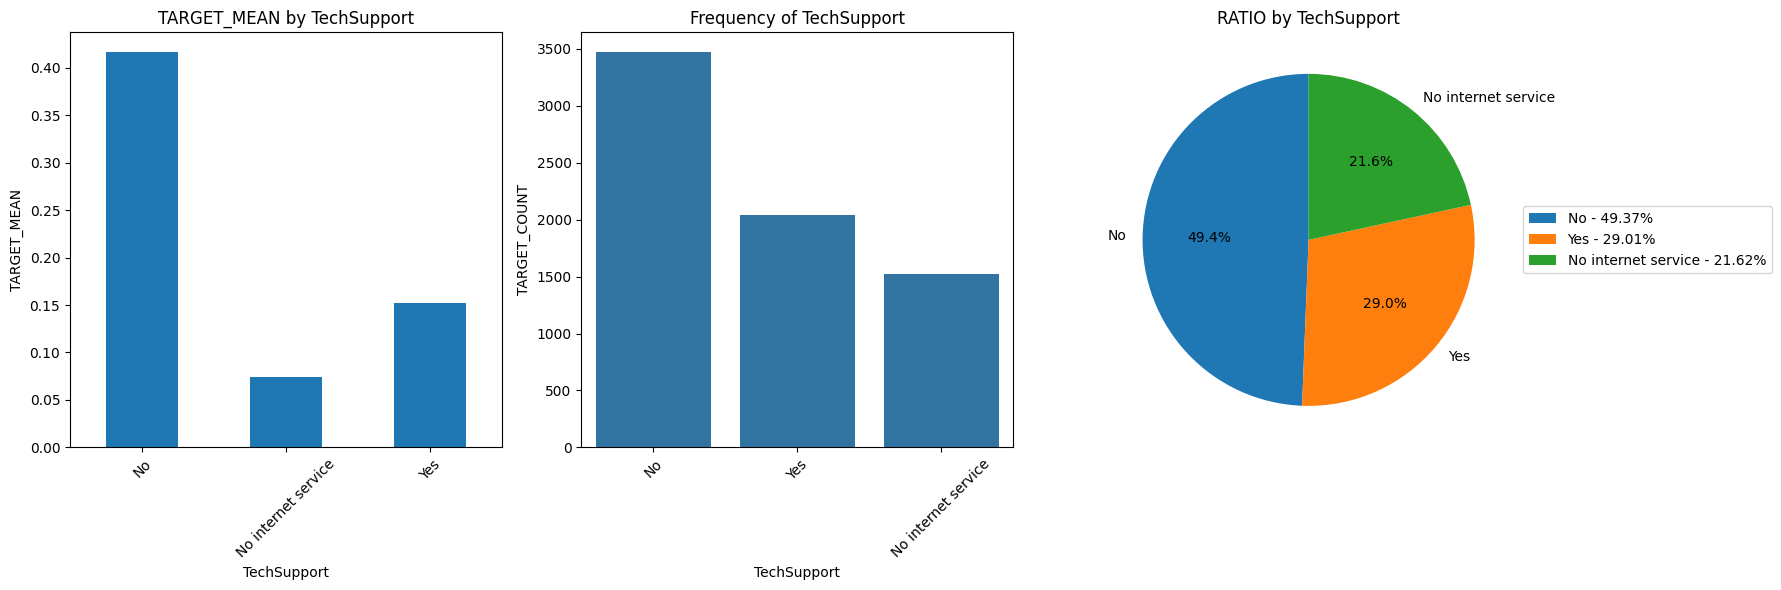

                     TARGET_MEAN  TARGET_COUNT  RATIO
StreamingTV                                          
No                         0.335          2809 39.946
No internet service        0.074          1520 21.615
Yes                        0.301          2703 38.439


##########################################


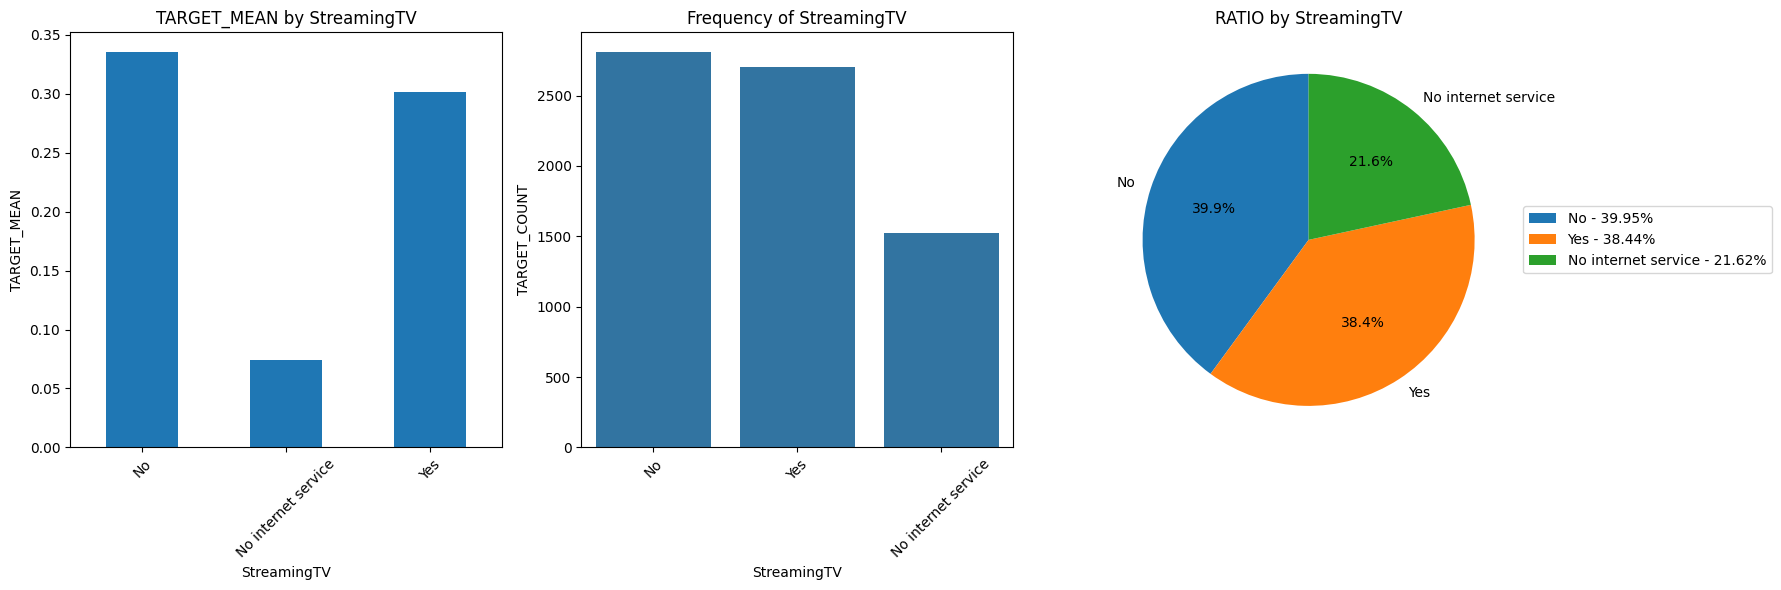

                     TARGET_MEAN  TARGET_COUNT  RATIO
StreamingMovies                                      
No                         0.337          2781 39.548
No internet service        0.074          1520 21.615
Yes                        0.300          2731 38.837


##########################################


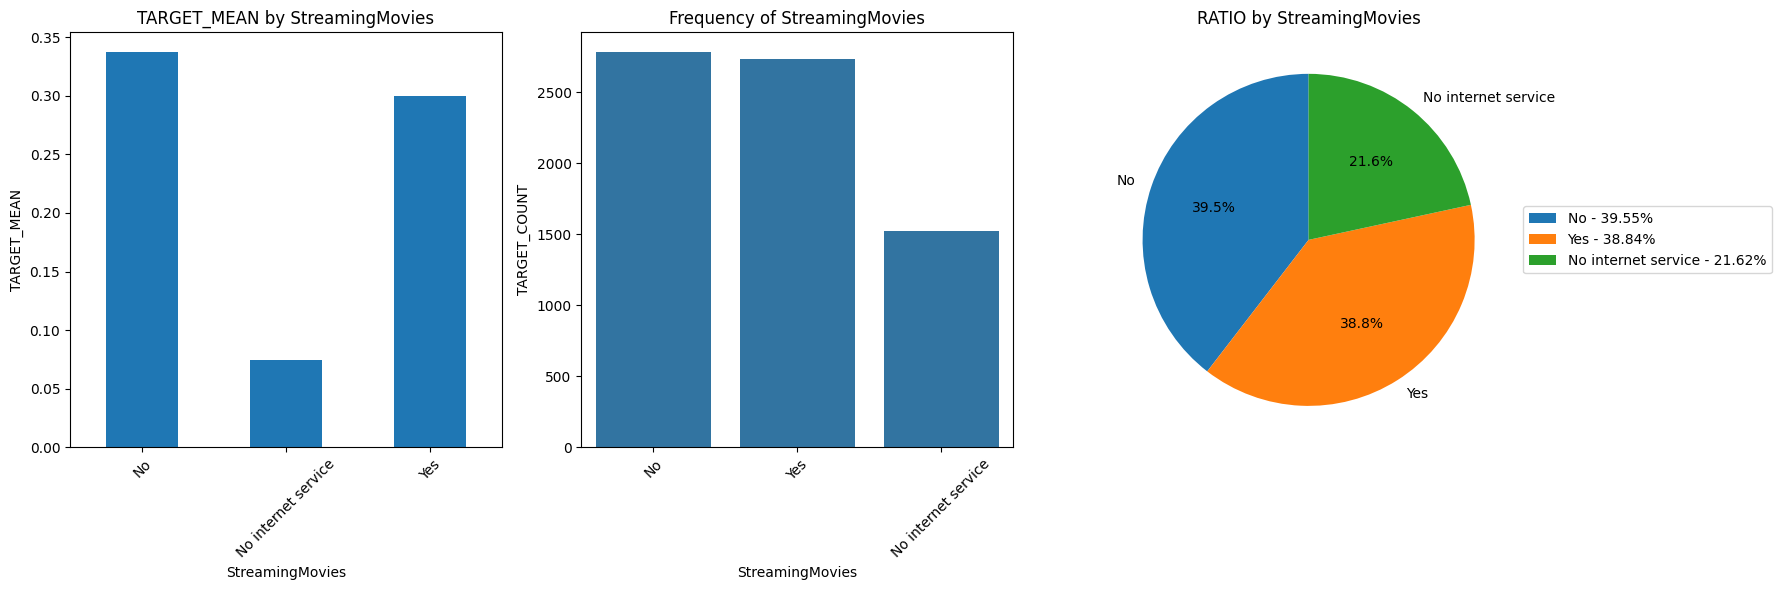

                TARGET_MEAN  TARGET_COUNT  RATIO
Contract                                        
Month-to-month        0.427          3875 55.105
One year              0.113          1472 20.933
Two year              0.028          1685 23.962


##########################################


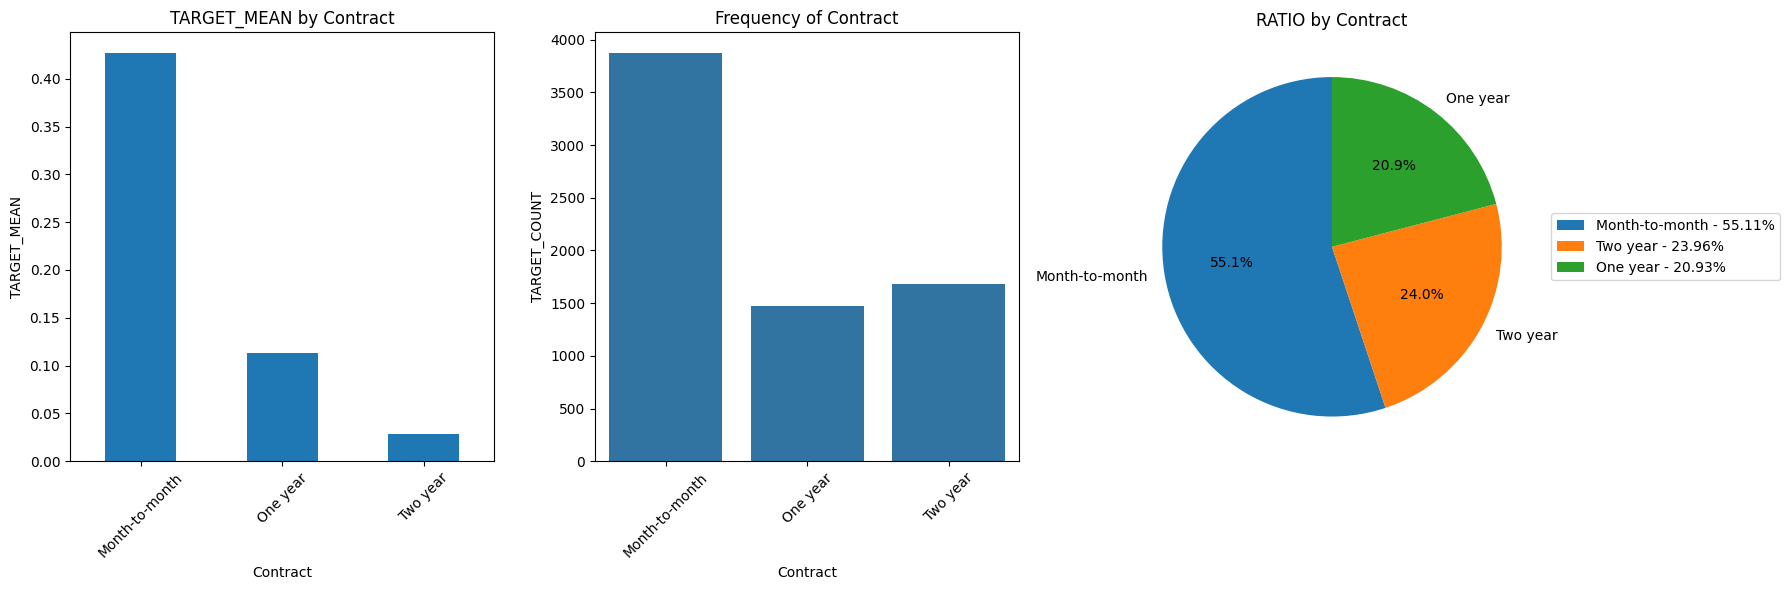

                  TARGET_MEAN  TARGET_COUNT  RATIO
PaperlessBilling                                  
No                      0.164          2864 40.728
Yes                     0.336          4168 59.272


##########################################


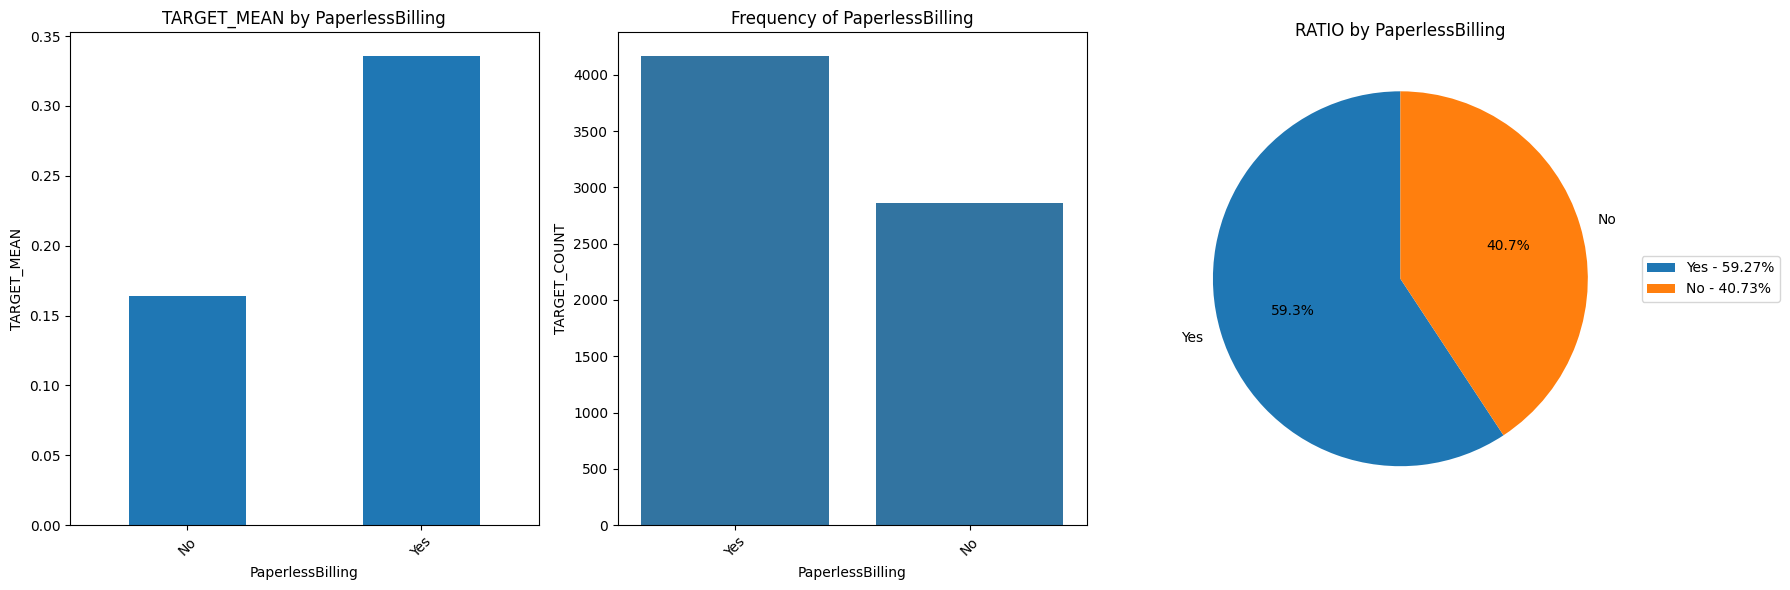

                           TARGET_MEAN  TARGET_COUNT  RATIO
PaymentMethod                                              
Bank transfer (automatic)        0.167          1542 21.928
Credit card (automatic)          0.153          1521 21.630
Electronic check                 0.453          2365 33.632
Mailed check                     0.192          1604 22.810


##########################################


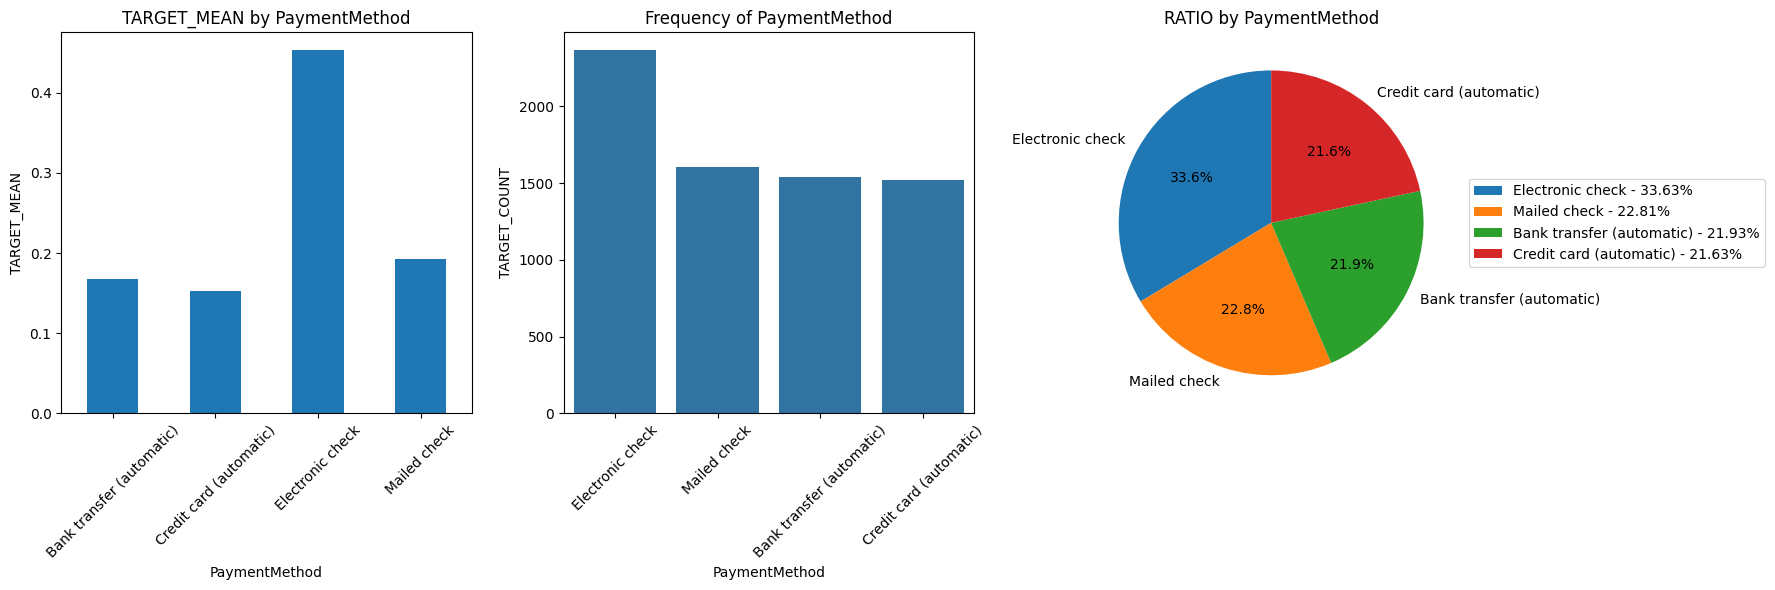

               TARGET_MEAN  TARGET_COUNT  RATIO
SeniorCitizen                                  
0                    0.237          5890 83.760
1                    0.417          1142 16.240


##########################################


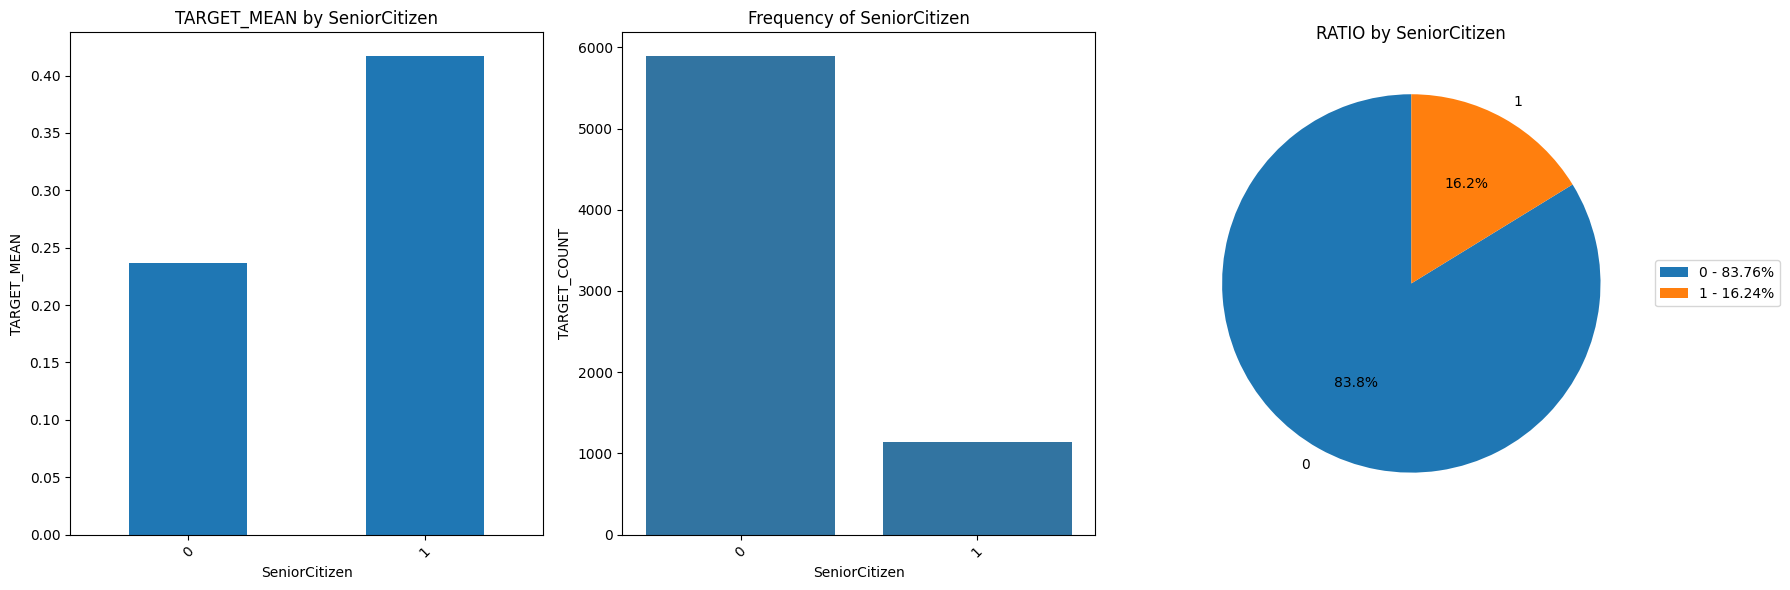

In [37]:
cat_cols = [col for col in cat_cols if "Churn" not in col]

for col in cat_cols:
    target_summary_with_cat(df, "Churn", col, plot=True)

In [38]:
def target_summary_with_num(dataframe, target, numerical_col, plot=False):
    # Group by target and calculate mean
    summary_df = dataframe.groupby(target).agg({numerical_col: "mean"})
    print(summary_df)
    print("##########################################")

    if plot:

        # Bar plot
        summary_df.plot(kind="bar", legend=False)
        plt.title(f"Mean of {numerical_col} by {target}")
        plt.xlabel(target)
        plt.ylabel(f"Mean of {numerical_col}")
        plt.show(block=True)

       tenure
Churn        
0      37.650
1      17.979
##########################################


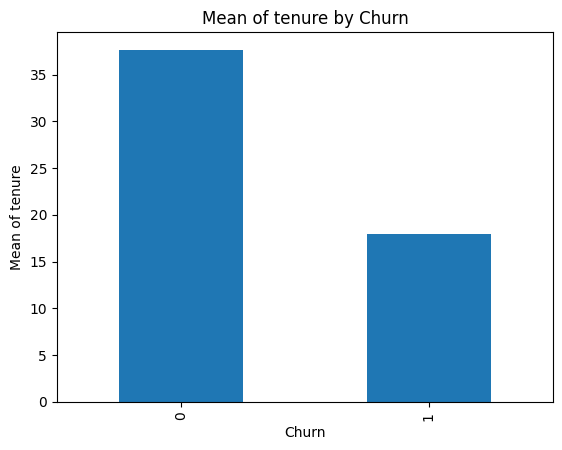

       MonthlyCharges
Churn                
0              61.307
1              74.441
##########################################


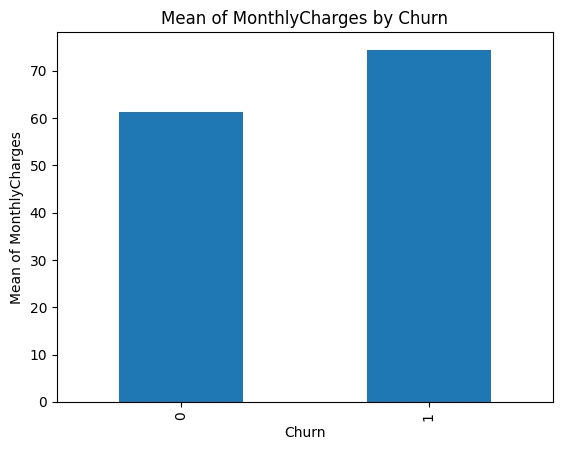

       TotalCharges
Churn              
0          2555.344
1          1531.796
##########################################


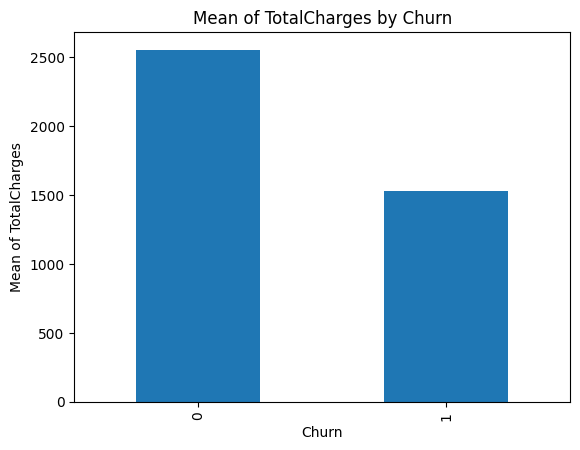

In [39]:
for col in num_cols:
    target_summary_with_num(df, "Churn", col, plot=True)

In [40]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [41]:
for col in num_cols:
    print(col, check_outlier(df, col))

tenure False
MonthlyCharges False
TotalCharges False


In [42]:
def missing_values_table(dataframe, na_name=False, plot=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=["n_miss", "ratio"])
    print(missing_df, end="\n")
    print("##########################################")

    if plot:
        plt.figure(figsize=(10, 8))
        plt.bar(missing_df.index, missing_df["ratio"])
        plt.xlabel("Features")
        plt.ylabel("Percentage of Missing Values")
        plt.title("Missing Values by Feature")

    if na_name:
        return na_columns

In [44]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.90):
    corr = dataframe.corr(numeric_only=True)
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        sns.set_theme(rc={"figure.figsize": (15, 15)})
        sns.heatmap(corr, annot=True, cmap="RdBu")
        plt.show()
    return drop_list

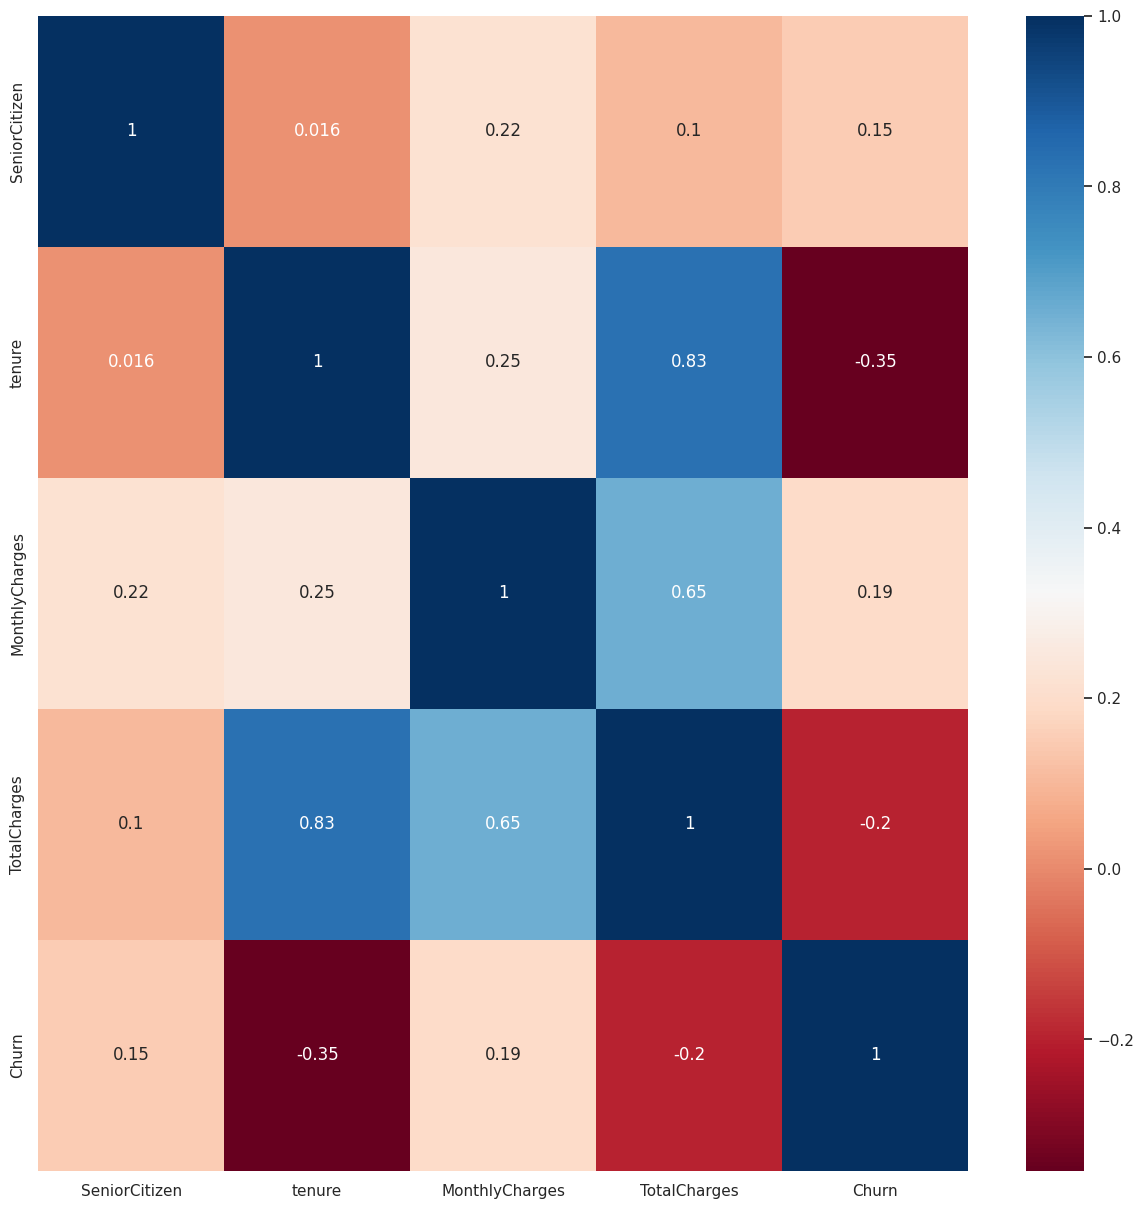

[]

In [45]:
high_correlated_cols(df, plot=True)

In [46]:
dff = df.copy()

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, dtype=int, drop_first=drop_first)
    return dataframe

dff = one_hot_encoder(dff, cat_cols, drop_first=True)
dff.head()

tenure  MonthlyCharges  TotalCharges  Churn  gender_Male  Partner_Yes  Dependents_Yes  PhoneService_Yes  MultipleLines_No phone service  MultipleLines_Yes  \
0       1          29.850        29.850      0            0            1               0                 0                               1                  0   
1      34          56.950      1889.500      0            1            0               0                 1                               0                  0   
2       2          53.850       108.150      1            1            0               0                 1                               0                  0   
3      45          42.300      1840.750      0            1            0               0                 0                               1                  0   
4       2          70.700       151.650      1            0            0               0                 1                               0                  0   

   InternetService_Fiber optic  InternetService_No  OnlineSecurity_No internet service  OnlineSecurity_Yes  OnlineBackup_No internet service  OnlineBackup_Yes  \
0                            0                   0                                   0                   0                                 0                 1   
1                            0                   0                                   0                   1                                 0                 0   
2                            0                   0                                   0                   1                                 0                 1   
3                            0                   0                                   0                   1                                 0                 0   
4                            1                   0                                   0                   0                                 0                 0   

   DeviceProtection_No internet service  DeviceProtection_Yes  TechSupport_No internet service  TechSupport_Yes  StreamingTV_No internet service  StreamingTV_Yes  \
0                                     0                     0                                0                0                                0                0   
1                                     0                     1                                0                0                                0                0   
2                                     0                     0                                0                0                                0                0   
3                                     0                     1                                0                1                                0                0   
4                                     0                     0                                0                0                                0                0   

   StreamingMovies_No internet service  StreamingMovies_Yes  Contract_One year  Contract_Two year  PaperlessBilling_Yes  PaymentMethod_Credit card (automatic)  \
0                                    0                    0                  0                  0                     1                                      0   
1                                    0                    0                  1                  0                     0                                      0   
2                                    0                    0                  0                  0                     1                                      0   
3                                    0                    0                  1                  0                     0                                      0   
4                                    0                    0                  0                  0                     1                                      0   

   PaymentMethod_Electronic check  PaymentMethod_Mailed check  SeniorCitizen_1  
0                 

In [47]:
y = dff["Churn"]
X = dff.drop(["Churn"], axis=1)

models = [("LR", LogisticRegression(random_state=42)),
          ("KNN", KNeighborsClassifier()),
          ("CART", DecisionTreeClassifier(random_state=42)),
          ("RF", RandomForestClassifier(random_state=42)),
          ("SVM", SVC(gamma="auto", random_state=42)),
          ("XGB", XGBClassifier(random_state=42)),
          ("LightGBM", LGBMClassifier(random_state=42, force_row_wise=True)),
          ("CatBoost", CatBoostClassifier(verbose=False, random_state=42))]

for name, model in models:
    cv_results = cross_validate(model, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc", "precision", "recall"])
    print(f"########## {name} ##########")
    print(f"Accuracy: {round(cv_results['test_accuracy'].mean(), 4)}")
    print(f"Auc: {round(cv_results['test_roc_auc'].mean(), 4)}")
    print(f"Recall: {round(cv_results['test_recall'].mean(), 4)}")
    print(f"Precision: {round(cv_results['test_precision'].mean(), 4)}")
    print(f"F1: {round(cv_results['test_f1'].mean(), 4)}")

########## LR ##########
Accuracy: 0.8019
Auc: 0.8428
Recall: 0.5356
Precision: 0.6567
F1: 0.5894
########## KNN ##########
Accuracy: 0.7634
Auc: 0.7462
Recall: 0.4468
Precision: 0.571
F1: 0.5008
########## CART ##########
Accuracy: 0.7297
Auc: 0.6598
Recall: 0.5056
Precision: 0.4925
F1: 0.4985
########## RF ##########
Accuracy: 0.7907
Auc: 0.824
Recall: 0.488
Precision: 0.6407
F1: 0.5536
########## SVM ##########
Accuracy: 0.7691
Auc: 0.7138
Recall: 0.2905
Precision: 0.6488
F1: 0.4008
########## XGB ##########
Accuracy: 0.786
Auc: 0.8237
Recall: 0.5179
Precision: 0.6178
F1: 0.563
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1682, number of negative: 4646
[LightGBM] [Info] Total Bins 637
[LightGBM] [Info] Number of data points in the train set: 6328, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265803 -> initscore=-1.016023
[LightGBM] [Info] Start training from score -1.016023
[Lig

In [48]:
y = dff["Churn"]
X = dff.drop(["Churn"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

model = RandomForestClassifier(random_state=42).fit(X_train, y_train)

y_pred = model.predict(X_test)

report = classification_report(y_test, y_pred, digits=4)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

print(report)
print(f"ROC AUC: {roc_auc:.4f}")

              precision    recall  f1-score   support

           0     0.8226    0.9039    0.8613      1041
           1     0.6198    0.4454    0.5183       366

    accuracy                         0.7846      1407
   macro avg     0.7212    0.6746    0.6898      1407
weighted avg     0.7698    0.7846    0.7721      1407

ROC AUC: 0.8096


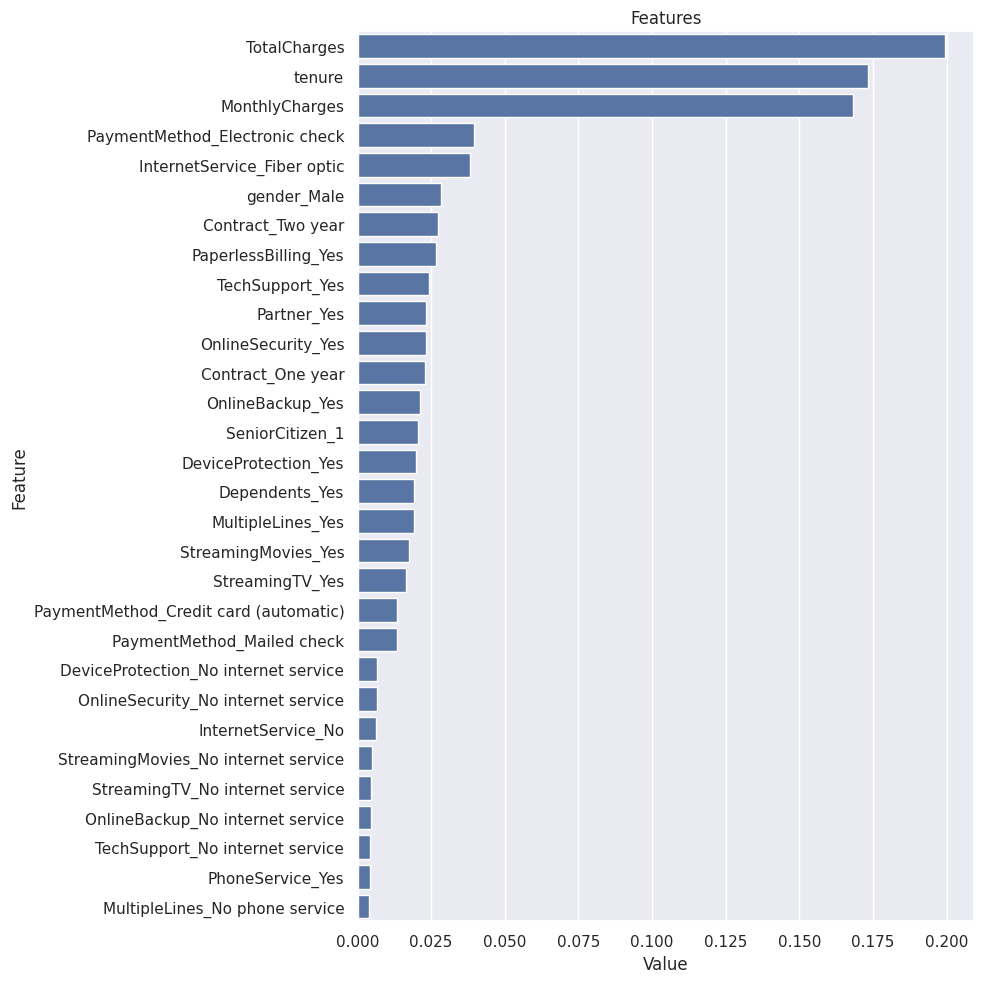

In [49]:
def plot_importance(model, features, dataframe, save=False):
    num = len(dataframe)
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(10, 10))
    sns.set_theme(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")

plot_importance(model, X_train, df)

In [50]:
def engineered_features(df):
    df_new = df.copy()

    # Annual Categorical Variable from Tenure
    df_new.loc[(df_new["tenure"]>=0) & (df_new["tenure"]<=12),"NewTenureYear"] = "0-1 Year"
    df_new.loc[(df_new["tenure"]>12) & (df_new["tenure"]<=24),"NewTenureYear"] = "1-2 Year"
    df_new.loc[(df_new["tenure"]>24) & (df_new["tenure"]<=36),"NewTenureYear"] = "2-3 Year"
    df_new.loc[(df_new["tenure"]>36) & (df_new["tenure"]<=48),"NewTenureYear"] = "3-4 Year"
    df_new.loc[(df_new["tenure"]>48) & (df_new["tenure"]<=60),"NewTenureYear"] = "4-5 Year"
    df_new.loc[(df_new["tenure"]>60) & (df_new["tenure"]<=72),"NewTenureYear"] = "5-6 Year"

    # Average Monthly Charges
    df_new["Avg_MonthlyCharges"] = df_new["TotalCharges"] / df_new["tenure"]

    # Total Services
    df_new["TotalServices"] = df_new[["PhoneService", "InternetService", "OnlineSecurity", "OnlineBackup",
                              "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]].apply(lambda x: (x == "Yes").sum(), axis=1)

    # Customer Lifetime Value (CLV)
    df_new["CLV"] = df_new["TotalCharges"] + (df_new["MonthlyCharges"] * (60 - df_new["tenure"]))  # Assuming 5 years (60 months) potential

    # Churn Risk Score
    df_new["ChurnRiskScore"] = ((df_new["Contract"] == "Month-to-month").astype(int) * 3 +
                            (df_new["PaperlessBilling"] == "Yes").astype(int) * 2 +
                            (df_new["PaymentMethod"] == "Electronic check").astype(int) * 2 +
                            (df_new["TotalServices"] < 2).astype(int) * 2 +
                            (df_new["tenure"] < 12).astype(int) * 3)

    # Service Satisfaction Index
    df_new["ServiceSatisfactionIndex"] = df_new[["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport"]].apply(lambda x: (x == "Yes").sum(), axis=1)

    # Engagement Score
    df_new["EngagementScore"] = df_new[["StreamingTV", "StreamingMovies"]].apply(lambda x: (x == "Yes").sum(), axis=1
                            ) + (df_new["InternetService"] != "No").astype(int) * 2 + (df_new["PhoneService"] == "Yes").astype(int)

    # Price Sensitivity
    df_new["PriceSensitivity"] = df_new["MonthlyCharges"] / df_new["TotalServices"].replace(0, 1)

    # Loyalty Index
    df_new["LoyaltyIndex"] = df_new["tenure"] * (df_new["Contract"] != "Month-to-month").astype(int)

    # Family Status
    df_new["FamilyStatus"] = ((df_new["Partner"] == "Yes") & (df_new["Dependents"] == "Yes")).astype(int)

    # Revenue Growth Rate
    df_new["RevenueGrowthRate"] = (df_new["MonthlyCharges"] - (df_new["TotalCharges"] / df_new["tenure"])) / (df_new["TotalCharges"] / df_new["tenure"])

    # Service Adoption Speed
    df_new["ServiceAdoptionSpeed"] = df_new["TotalServices"] / df_new["tenure"]

    # Contract Commitment Level
    df_new["ContractCommitmentLevel"] = df_new["Contract"].map({"Month-to-month": 1, "One year": 12, "Two year": 24})

    # Tech Savviness Score
    df_new["TechSavvinessScore"] = ((df_new["OnlineSecurity"] == "Yes").astype(int) +
                                (df_new["OnlineBackup"] == "Yes").astype(int) +
                                (df_new["DeviceProtection"] == "Yes").astype(int) +
                                (df_new["TechSupport"] == "Yes").astype(int) +
                                (df_new["InternetService"] == "Fiber optic").astype(int) * 2)

    # Payment Reliability
    df_new["PaymentReliability"] = (df_new["PaymentMethod"].isin(["Bank transfer (automatic)", "Credit card (automatic)"])).astype(int)

    # Customer Cost
    df_new["CustomerCost"] = df_new["TotalCharges"] / (df_new["tenure"] + 1)  # Adding 1 to avoid division by zero

    # Service Value Ratio
    df_new["ServiceValueRatio"] = df_new["TotalServices"] / df_new["MonthlyCharges"]

    # Longevity-Adjusted CLV
    df_new["LongevityAdjustedCLV"] = df_new["CLV"] * (1 + (df_new["tenure"] / 72))  # Assuming max tenure is 72 months (6 years)

    # Churn Probability (simple logistic function of ChurnRiskScore)
    df_new["ChurnProbability"] = 1 / (1 + np.exp(-df_new["ChurnRiskScore"] / 10))

    df_new.rename(columns={"tenure": "Tenure"}, inplace=True)

    return df_new

In [51]:
df = engineered_features(df)

df.head()

gender  SeniorCitizen Partner Dependents  Tenure PhoneService     MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV  \
0  Female              0     Yes         No       1           No  No phone service             DSL             No          Yes               No          No          No   
1    Male              0      No         No      34          Yes                No             DSL            Yes           No              Yes          No          No   
2    Male              0      No         No       2          Yes                No             DSL            Yes          Yes               No          No          No   
3    Male              0      No         No      45           No  No phone service             DSL            Yes           No              Yes         Yes          No   
4  Female              0      No         No       2          Yes                No     Fiber optic             No           No               No          No          No   

  StreamingMovies        Contract PaperlessBilling              PaymentMethod  MonthlyCharges  TotalCharges  Churn NewTenureYear  Avg_MonthlyCharges  TotalServices  \
0              No  Month-to-month              Yes           Electronic check          29.850        29.850      0      0-1 Year              29.850              1   
1              No        One year               No               Mailed check          56.950      1889.500      0      2-3 Year              55.574              3   
2              No  Month-to-month              Yes               Mailed check          53.850       108.150      1      0-1 Year              54.075              3   
3              No        One year               No  Bank transfer (automatic)          42.300      1840.750      0      3-4 Year              40.906              3   
4              No  Month-to-month              Yes           Electronic check          70.700       151.650      1      0-1 Year              75.825              1   

       CLV  ChurnRiskScore  ServiceSatisfactionIndex  EngagementScore  PriceSensitivity  LoyaltyIndex  FamilyStatus  RevenueGrowthRate  ServiceAdoptionSpeed  \
0 1791.000              12                         1                2            29.850             0             0              0.000                 1.000   
1 3370.200               0                         2                3            18.983            34             0              0.025                 0.088   
2 3231.450               8                         2                3            17.950             0             0             -0.004                 1.500   
3 2475.250               0                         3                2            14.100            45             0              0.034                 0.067   
4 4252.250              12                         0                3            70.700             0             0             -0.068                 0.500   

   ContractCommitmentLevel  TechSavvinessScore  PaymentReliability  CustomerCost  ServiceValueRatio  LongevityAdjustedCLV  ChurnProbability  
0                        1                   1                   0        14.925              0.034              1815.875             0.769  
1                       12                   2                   0        53.986              0.053              4961.683             0.500  
2                        1                   2                   0        36.050              0.056              3321.213             0.690  
3                       12                   3                   1        40.016              0.071              4022.281             0.500  
4                        1                   2                   0        50.550              0.014              4370.368             0.769

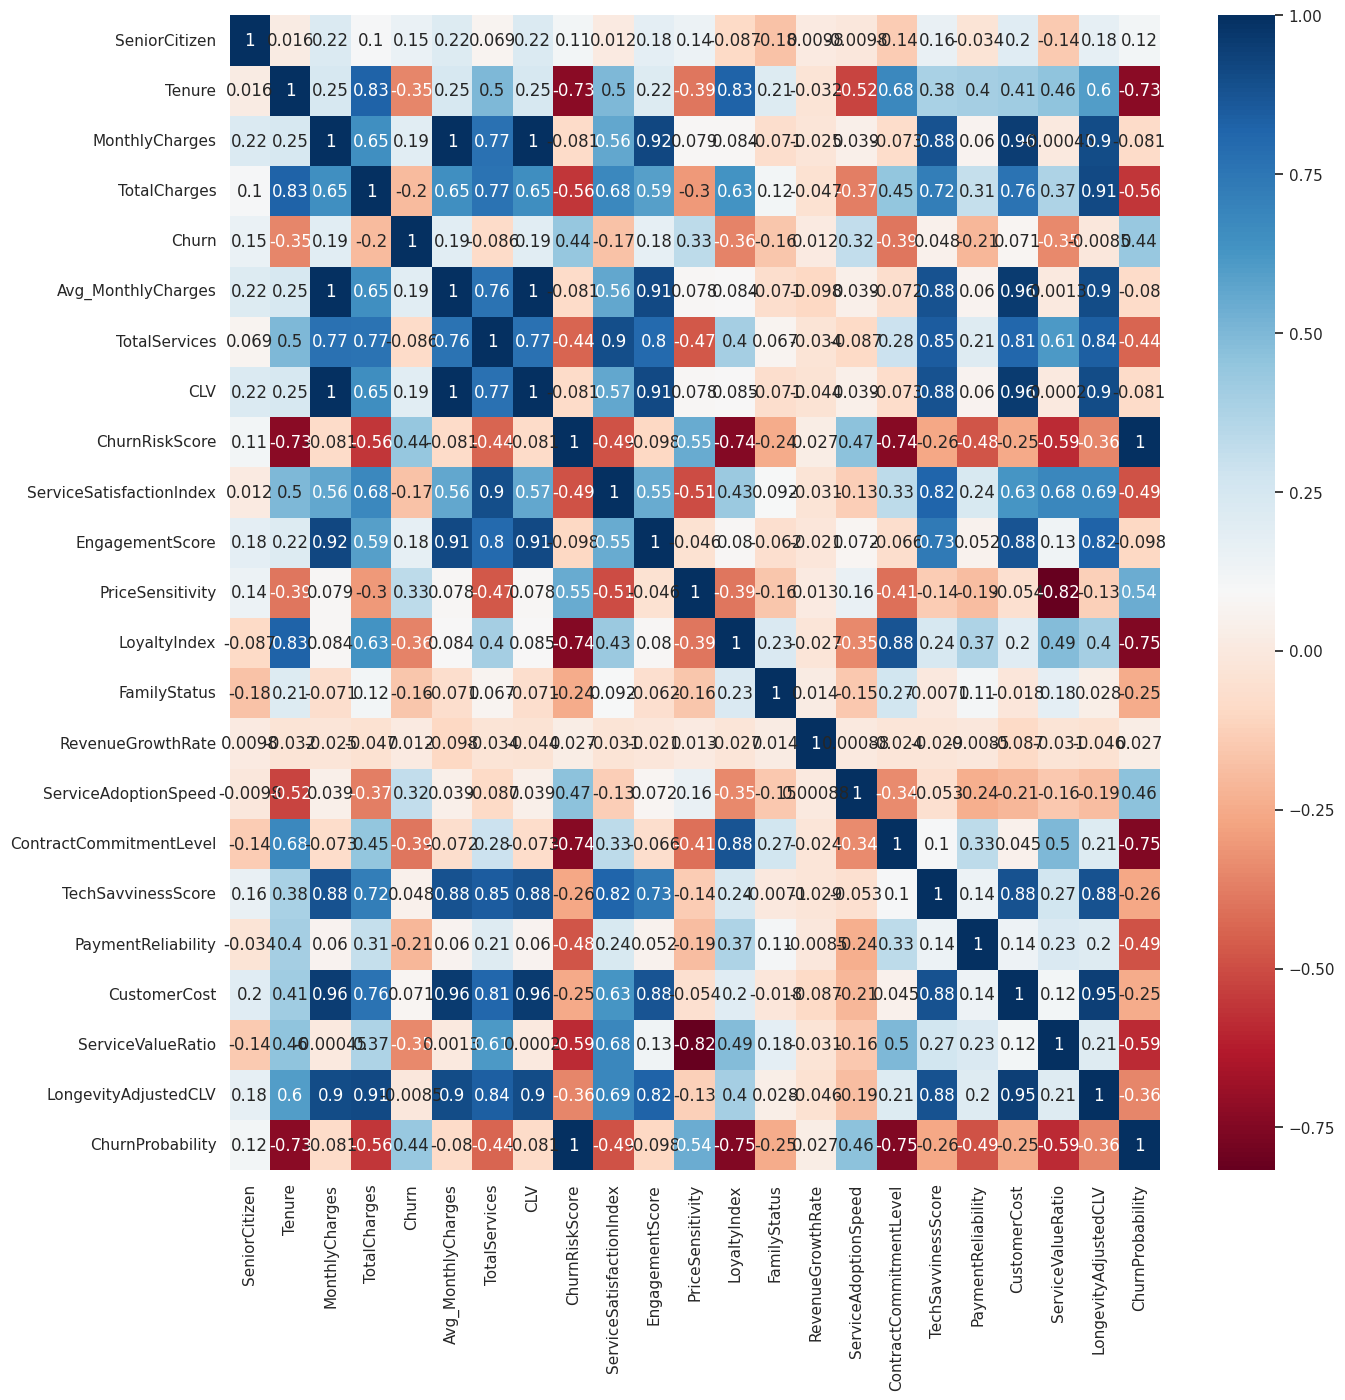

['Avg_MonthlyCharges',
 'CLV',
 'EngagementScore',
 'CustomerCost',
 'LongevityAdjustedCLV',
 'ChurnProbability']

In [53]:
drop_list = high_correlated_cols(df, plot=True, corr_th=0.90)
drop_list

In [54]:
df.drop(columns=drop_list, inplace=True)

df.head()

gender  SeniorCitizen Partner Dependents  Tenure PhoneService     MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV  \
0  Female              0     Yes         No       1           No  No phone service             DSL             No          Yes               No          No          No   
1    Male              0      No         No      34          Yes                No             DSL            Yes           No              Yes          No          No   
2    Male              0      No         No       2          Yes                No             DSL            Yes          Yes               No          No          No   
3    Male              0      No         No      45           No  No phone service             DSL            Yes           No              Yes         Yes          No   
4  Female              0      No         No       2          Yes                No     Fiber optic             No           No               No          No          No   

  StreamingMovies        Contract PaperlessBilling              PaymentMethod  MonthlyCharges  TotalCharges  Churn NewTenureYear  TotalServices  ChurnRiskScore  \
0              No  Month-to-month              Yes           Electronic check          29.850        29.850      0      0-1 Year              1              12   
1              No        One year               No               Mailed check          56.950      1889.500      0      2-3 Year              3               0   
2              No  Month-to-month              Yes               Mailed check          53.850       108.150      1      0-1 Year              3               8   
3              No        One year               No  Bank transfer (automatic)          42.300      1840.750      0      3-4 Year              3               0   
4              No  Month-to-month              Yes           Electronic check          70.700       151.650      1      0-1 Year              1              12   

   ServiceSatisfactionIndex  PriceSensitivity  LoyaltyIndex  FamilyStatus  RevenueGrowthRate  ServiceAdoptionSpeed  ContractCommitmentLevel  TechSavvinessScore  \
0                         1            29.850             0             0              0.000                 1.000                        1                   1   
1                         2            18.983            34             0              0.025                 0.088                       12                   2   
2                         2            17.950             0             0             -0.004                 1.500                        1                   2   
3                         3            14.100            45             0              0.034                 0.067                       12                   3   
4                         0            70.700             0             0             -0.068                 0.500                        1                   2   

   PaymentReliability  ServiceValueRatio  
0                   0              0.034  
1                   0              0.053  
2                   0              0.056  
3                   1              0.071  
4                   0              0.014

In [72]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)
print("#############")
print(f"Cat_Cols : {cat_cols}")
print("#############")
print(f"Num_Cols : {num_cols}")
print("#############")
print(f"Cat_But_Car : {cat_but_car}")

Observations: 7032
Variables: 60
cat_cols: 51
num_cols: 9
cat_but_car: 0
num_but_cat: 50
#############
Cat_Cols : ['NewTenureYear', 'Churn', 'TotalServices', 'ServiceSatisfactionIndex', 'FamilyStatus', 'ContractCommitmentLevel', 'TechSavvinessScore', 'PaymentReliability', 'gender_0', 'gender_1', 'Partner_0', 'Partner_1', 'Dependents_0', 'Dependents_1', 'PhoneService_0', 'PhoneService_1', 'MultipleLines_No', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No', 'StreamingMovies_No internet service', 'Streaming

In [73]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]

for col in binary_cols:
    df = label_encoder(df, col)

df.head()

Tenure  MonthlyCharges  TotalCharges  Churn NewTenureYear  TotalServices  ChurnRiskScore  ServiceSatisfactionIndex  PriceSensitivity  LoyaltyIndex  FamilyStatus  \
0  -0.609          -0.746        -0.403      0      0-1 Year         -0.667           1.167                         1             0.918         0.000             0   
1   0.109          -0.247         0.145      0      2-3 Year          0.000          -0.833                         2            -0.194         0.654             0   
2  -0.587          -0.304        -0.380      1      0-1 Year          0.000           0.500                         2            -0.300         0.000             0   
3   0.348          -0.517         0.131      0      3-4 Year          0.000          -0.833                         3            -0.694         0.865             0   
4  -0.587           0.006        -0.367      1      0-1 Year         -0.667           1.167                         0             5.101         0.000             0   

   RevenueGrowthRate  ServiceAdoptionSpeed  ContractCommitmentLevel  TechSavvinessScore  PaymentReliability  ServiceValueRatio  gender_0  gender_1  Partner_0  \
0              0.000                 5.000                        1                   1                   0             -0.743         1         0          0   
1              0.618                -0.065                       12                   2                   0              0.247         0         1          1   
2             -0.104                 7.778                        1                   2                   0              0.404         0         1          1   
3              0.851                -0.185                       12                   3                   1              1.189         0         1          1   
4             -1.687                 2.222                        1                   2                   0             -1.743         1         0          1   

   Partner_1  Dependents_0  Dependents_1  PhoneService_0  PhoneService_1  MultipleLines_No  MultipleLines_No phone service  MultipleLines_Yes  InternetService_DSL  \
0          1             1             0               1               0                 0                               1                  0                    1   
1          0             1             0               0               1                 1                               0                  0                    1   
2          0             1             0               0               1                 1                               0                  0                    1   
3          0             1             0               1               0                 0                               1                  0                    1   
4          0             1             0               0               1                 1                               0                  0                    0   

   InternetService_Fiber optic  InternetService_No  OnlineSecurity_No  OnlineSecurity_No internet service  OnlineSecurity_Yes  OnlineBackup_No  \
0                            0                   0                  1                                   0                   0                0   
1                            0                   0                  0                                   0                   1                1   
2                            0                   0                  0                                   0                   1                0   
3                            0                   0                  0                                   0                   1                1   
4                            1                   0                  1                                   0                   0                1   

   OnlineBackup_No internet service  OnlineBackup_Yes  DeviceProtection_No  DeviceProtection_No internet service  DeviceProtection_Yes  TechSupport_No  \
0    

In [74]:
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["Churn", "TotalServices"]]

In [75]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, dtype=int, drop_first=drop_first)
    return dataframe


In [76]:
df = one_hot_encoder(df, cat_cols)

df.head()

Tenure  MonthlyCharges  TotalCharges  Churn  TotalServices  ChurnRiskScore  PriceSensitivity  LoyaltyIndex  RevenueGrowthRate  ServiceAdoptionSpeed  \
0  -0.609          -0.746        -0.403      0         -0.667           1.167             0.918         0.000              0.000                 5.000   
1   0.109          -0.247         0.145      0          0.000          -0.833            -0.194         0.654              0.618                -0.065   
2  -0.587          -0.304        -0.380      1          0.000           0.500            -0.300         0.000             -0.104                 7.778   
3   0.348          -0.517         0.131      0          0.000          -0.833            -0.694         0.865              0.851                -0.185   
4  -0.587           0.006        -0.367      1         -0.667           1.167             5.101         0.000             -1.687                 2.222   

   ServiceValueRatio  NewTenureYear_0-1 Year  NewTenureYear_1-2 Year  NewTenureYear_2-3 Year  NewTenureYear_3-4 Year  NewTenureYear_4-5 Year  NewTenureYear_5-6 Year  \
0             -0.743                       1                       0                       0                       0                       0                       0   
1              0.247                       0                       0                       1                       0                       0                       0   
2              0.404                       1                       0                       0                       0                       0                       0   
3              1.189                       0                       0                       0                       1                       0                       0   
4             -1.743                       1                       0                       0                       0                       0                       0   

   ServiceSatisfactionIndex_0  ServiceSatisfactionIndex_1  ServiceSatisfactionIndex_2  ServiceSatisfactionIndex_3  ServiceSatisfactionIndex_4  FamilyStatus_0  \
0                           0                           1                           0                           0                           0               1   
1                           0                           0                           1                           0                           0               1   
2                           0                           0                           1                           0                           0               1   
3                           0                           0                           0                           1                           0               1   
4                           1                           0                           0                           0                           0               1   

   FamilyStatus_1  ContractCommitmentLevel_1  ContractCommitmentLevel_12  ContractCommitmentLevel_24  TechSavvinessScore_0  TechSavvinessScore_1  TechSavvinessScore_2  \
0               0                          1                           0                           0                     0                     1                     0   
1               0                          0                           1                           0                     0                     0                     1   
2               0                          1                           0                           0                     0                     0                     1   
3               0                          0                           1                           0                     0                     0                     0   
4               0                          1                           0                           0                     0                     0                     1   

   TechSavvinessScore_3  TechSavvinessScore_4  TechSavvinessScore_5  TechSavvines

In [77]:
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

In [78]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["Churn", "TotalServices"]]

cat_cols

Observations: 7032
Variables: 122
cat_cols: 113
num_cols: 9
cat_but_car: 0
num_but_cat: 113


['NewTenureYear_0-1 Year',
 'NewTenureYear_1-2 Year',
 'NewTenureYear_2-3 Year',
 'NewTenureYear_3-4 Year',
 'NewTenureYear_4-5 Year',
 'NewTenureYear_5-6 Year',
 'ServiceSatisfactionIndex_0',
 'ServiceSatisfactionIndex_1',
 'ServiceSatisfactionIndex_2',
 'ServiceSatisfactionIndex_3',
 'ServiceSatisfactionIndex_4',
 'FamilyStatus_0',
 'FamilyStatus_1',
 'ContractCommitmentLevel_1',
 'ContractCommitmentLevel_12',
 'ContractCommitmentLevel_24',
 'TechSavvinessScore_0',
 'TechSavvinessScore_1',
 'TechSavvinessScore_2',
 'TechSavvinessScore_3',
 'TechSavvinessScore_4',
 'TechSavvinessScore_5',
 'TechSavvinessScore_6',
 'PaymentReliability_0',
 'PaymentReliability_1',
 'gender_0_0',
 'gender_0_1',
 'gender_1_0',
 'gender_1_1',
 'Partner_0_0',
 'Partner_0_1',
 'Partner_1_0',
 'Partner_1_1',
 'Dependents_0_0',
 'Dependents_0_1',
 'Dependents_1_0',
 'Dependents_1_1',
 'PhoneService_0_0',
 'PhoneService_0_1',
 'PhoneService_1_0',
 'PhoneService_1_1',
 'MultipleLines_No_0',
 'MultipleLines_No_1'

In [79]:
 rare_analyser(df, "Churn", cat_cols)

NewTenureYear_0-1 Year : 2
                        COUNT  RATIO  TARGET_MEAN
NewTenureYear_0-1 Year                           
0                        4857  0.691        0.171
1                        2175  0.309        0.477


NewTenureYear_1-2 Year : 2
                        COUNT  RATIO  TARGET_MEAN
NewTenureYear_1-2 Year                           
0                        6008  0.854        0.262
1                        1024  0.146        0.287


NewTenureYear_2-3 Year : 2
                        COUNT  RATIO  TARGET_MEAN
NewTenureYear_2-3 Year                           
0                        6200  0.882        0.272
1                         832  0.118        0.216


NewTenureYear_3-4 Year : 2
                        COUNT  RATIO  TARGET_MEAN
NewTenureYear_3-4 Year                           
0                        6270  0.892        0.275
1                         762  0.108        0.190


NewTenureYear_4-5 Year : 2
                        COUNT  RATIO  TARGET_MEAN
NewTenu

In [80]:
useless_cols=[col for col in df.columns if df[col].nunique() == 2 and
                (df[col].value_counts() / len(df) < 0.01).any(axis=None)]

useless_cols

[]

In [81]:
num_cols.append("TotalServices")
num_cols

['Tenure',
 'MonthlyCharges',
 'TotalCharges',
 'ChurnRiskScore',
 'PriceSensitivity',
 'LoyaltyIndex',
 'RevenueGrowthRate',
 'ServiceAdoptionSpeed',
 'ServiceValueRatio',
 'TotalServices']

In [82]:
scaler = RobustScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [83]:
df.head()

Tenure  MonthlyCharges  TotalCharges  Churn  TotalServices  ChurnRiskScore  PriceSensitivity  LoyaltyIndex  RevenueGrowthRate  ServiceAdoptionSpeed  \
0  -0.609          -0.746        -0.403      0         -0.667           1.167             0.918         0.000              0.000                 5.000   
1   0.109          -0.247         0.145      0          0.000          -0.833            -0.194         0.654              0.618                -0.065   
2  -0.587          -0.304        -0.380      1          0.000           0.500            -0.300         0.000             -0.104                 7.778   
3   0.348          -0.517         0.131      0          0.000          -0.833            -0.694         0.865              0.851                -0.185   
4  -0.587           0.006        -0.367      1         -0.667           1.167             5.101         0.000             -1.687                 2.222   

   ServiceValueRatio  NewTenureYear_0-1 Year  NewTenureYear_1-2 Year  NewTenureYear_2-3 Year  NewTenureYear_3-4 Year  NewTenureYear_4-5 Year  NewTenureYear_5-6 Year  \
0             -0.743                       1                       0                       0                       0                       0                       0   
1              0.247                       0                       0                       1                       0                       0                       0   
2              0.404                       1                       0                       0                       0                       0                       0   
3              1.189                       0                       0                       0                       1                       0                       0   
4             -1.743                       1                       0                       0                       0                       0                       0   

   ServiceSatisfactionIndex_0  ServiceSatisfactionIndex_1  ServiceSatisfactionIndex_2  ServiceSatisfactionIndex_3  ServiceSatisfactionIndex_4  FamilyStatus_0  \
0                           0                           1                           0                           0                           0               1   
1                           0                           0                           1                           0                           0               1   
2                           0                           0                           1                           0                           0               1   
3                           0                           0                           0                           1                           0               1   
4                           1                           0                           0                           0                           0               1   

   FamilyStatus_1  ContractCommitmentLevel_1  ContractCommitmentLevel_12  ContractCommitmentLevel_24  TechSavvinessScore_0  TechSavvinessScore_1  TechSavvinessScore_2  \
0               0                          1                           0                           0                     0                     1                     0   
1               0                          0                           1                           0                     0                     0                     1   
2               0                          1                           0                           0                     0                     0                     1   
3               0                          0                           1                           0                     0                     0                     0   
4               0                          1                           0                           0                     0                     0                     1   

   TechSavvinessScore_3  TechSavvinessScore_4  TechSavvinessScore_5  TechSavvines

In [84]:
y = df["Churn"]
X = df.drop(["Churn"], axis=1)

In [85]:
rf_model = RandomForestClassifier(random_state=42)

rf_params = {"max_depth": [5, 8],
             "max_features": [3, 5],
             "min_samples_split": [2, 5, 8],
             "n_estimators": [200, 500]}

rf_best_grid = GridSearchCV(rf_model, rf_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [86]:
rf_best_grid.best_params_

{'max_depth': 8,
 'max_features': 5,
 'min_samples_split': 8,
 'n_estimators': 500}

In [87]:
rf_best_grid.best_score_


0.8016191143449589

In [88]:
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X, y)

cv_results = cross_validate(rf_final, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])

print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
print(f"F1-Score: {cv_results['test_f1'].mean()}")
print(f"Roc-Auc Score: {cv_results['test_roc_auc'].mean()}")

Accuracy: 0.8009100607784818
F1-Score: 0.5699778011848943
Roc-Auc Score: 0.8445809458136212


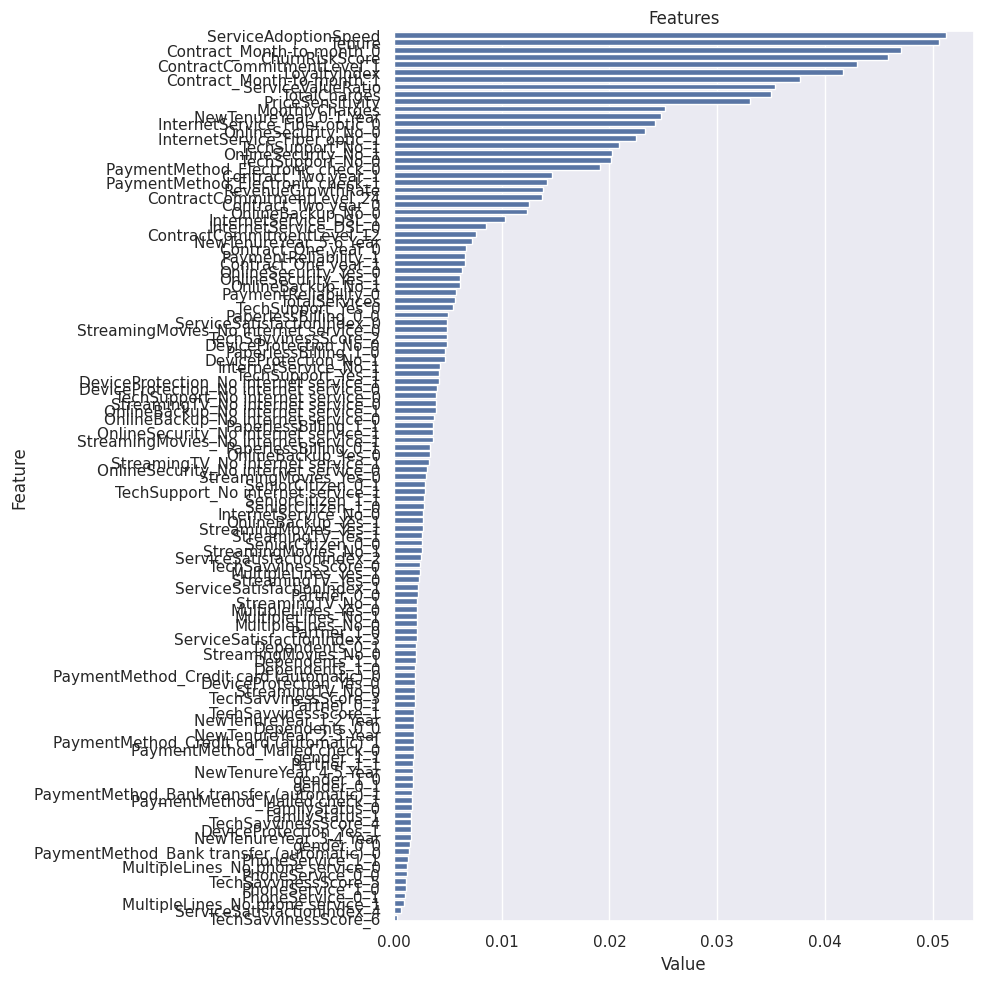

In [89]:
def plot_importance(model, features, dataframe, save=False):
    num = len(dataframe)
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(10, 10))
    sns.set_theme(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")

plot_importance(rf_final, X, df)